<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 02 - Petkovski


The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k

import time

In [23]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


## Mount Google Drive to Colab Environment

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## EDA Functions

In [2]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)

    x = x[indices]
    y = y[indices]

    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)

    x = x[indices]
    y = y[indices]

    y = tf.keras.utils.to_categorical(y)

    return x, y

In [3]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)

    x = x[indices]
    y = y[indices]
    p = p[indices]

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [4]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

In [5]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions))))

In [6]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test
* Imported 50000 labels for training and 10000 labels for test

In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels

In [ ]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [8]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [9]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

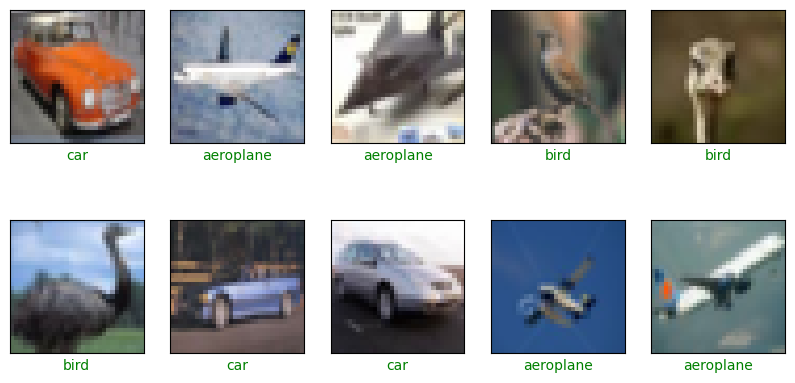

In [24]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [10]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [11]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [ ]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255


1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [12]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/CNN_architecture_v4.png?raw=1">


## Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle classification

In [ ]:
k.clear_session()
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)
])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 256)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)         0

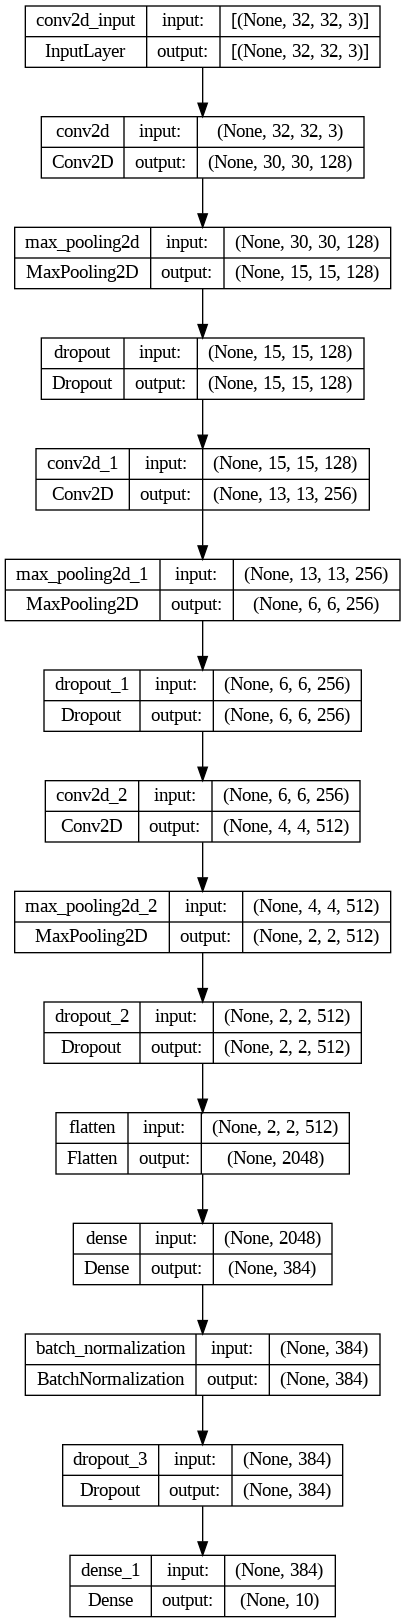

In [ ]:
tf.keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True)

## Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [ ]:
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )

Epoch 1/200
704/704 [==============================] - 18s 15ms/step - loss: 1.6854 - accuracy: 0.4116 - val_loss: 1.4595 - val_accuracy: 0.5096
Epoch 2/200
  5/704 [..............................] - ETA: 8s - loss: 1.4207 - accuracy: 0.5406 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 10s 14ms/step - loss: 1.3318 - accuracy: 0.5600 - val_loss: 1.1981 - val_accuracy: 0.6018
Epoch 3/200
704/704 [==============================] - 10s 14ms/step - loss: 1.1873 - accuracy: 0.6193 - val_loss: 1.2000 - val_accuracy: 0.6068
Epoch 4/200
704/704 [==============================] - 9s 13ms/step - loss: 1.0959 - accuracy: 0.6577 - val_loss: 1.2501 - val_accuracy: 0.6040
Epoch 5/200
704/704 [==============================] - 10s 14ms/step - loss: 1.0276 - accuracy: 0.6827 - val_loss: 1.1331 - val_accuracy: 0.6466
Epoch 6/200
704/704 [==============================] - 10s 14ms/step - loss: 0.9728 - accuracy: 0.7020 - val_loss: 0.9059 - val_accuracy: 0.7198
Epoch 7/200
704/704 [==============================] - 10s 14ms/step - loss: 0.9250 - accuracy: 0.7209 - val_loss: 0.9023 - val_accuracy: 0.7220
Epoch 8/200
704/704 [==============================] - 10s 14ms/step - loss: 0.8932 - accuracy: 0.7327 - val_loss: 0.9066 - val_accuracy: 0.728

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
model = tf.keras.models.load_model("CNN_model.h5")
print(f"Test acc: {model.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.7582 - accuracy: 0.7818
Test acc: 0.782


## Predictions

In [ ]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 1s 3ms/step
shape of preds:  (10000, 10)


## Plotting Performance Metrics

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
18,0.688,0.805,0.743,0.782
19,0.669,0.811,0.727,0.795
20,0.664,0.815,0.744,0.785
21,0.653,0.816,0.783,0.772
22,0.641,0.822,0.726,0.789


## Plot Training Metrics (Loss and Accuracy)

<ipython-input-7-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


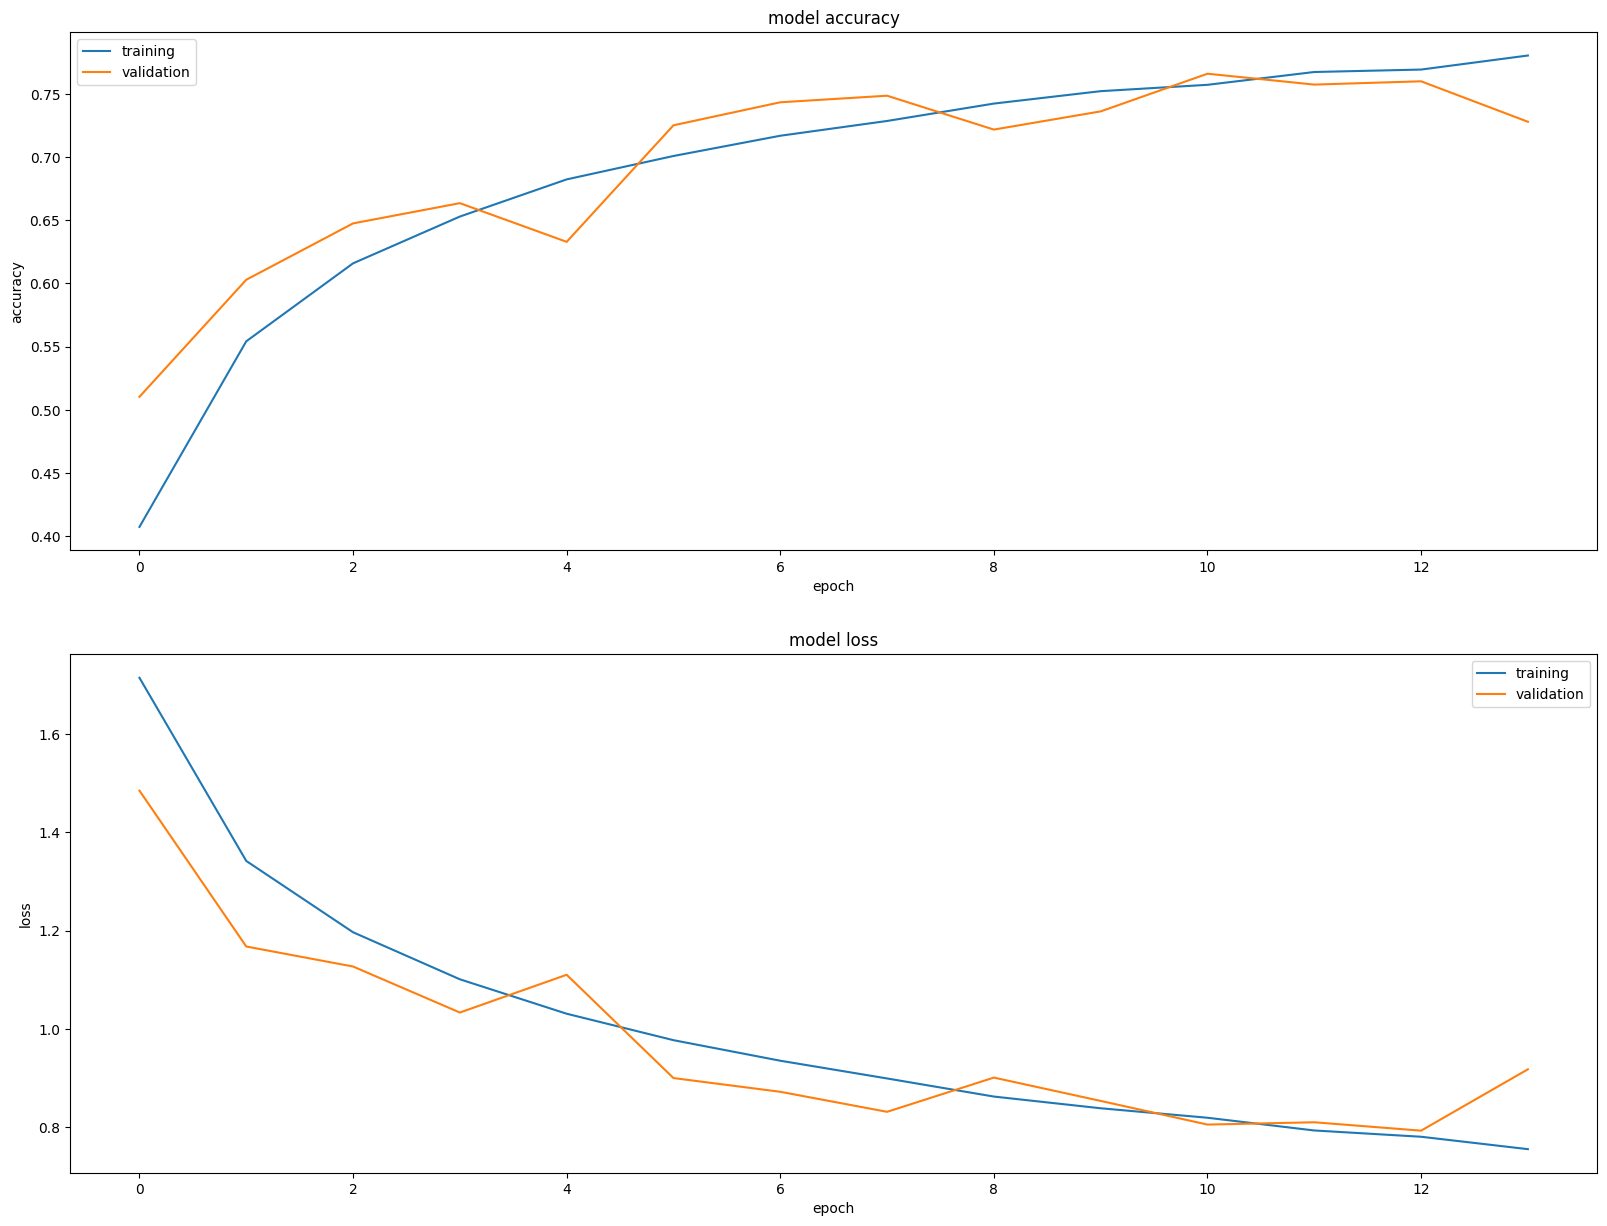

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_df['accuracy'], history_df['val_accuracy'], 'accuracy', 211)
display_training_curves(history_df['loss'], history_df['val_loss'], 'loss', 212)

## Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [ ]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 1s 4ms/step


In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.94      0.86      0.90      1000
           2       0.73      0.65      0.69      1000
           3       0.56      0.71      0.63      1000
           4       0.76      0.73      0.75      1000
           5       0.82      0.61      0.70      1000
           6       0.74      0.90      0.81      1000
           7       0.86      0.80      0.83      1000
           8       0.83      0.89      0.86      1000
           9       0.88      0.84      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

Accuracy Score: 0.7818
Root Mean Square Error: 1.8989470766717012


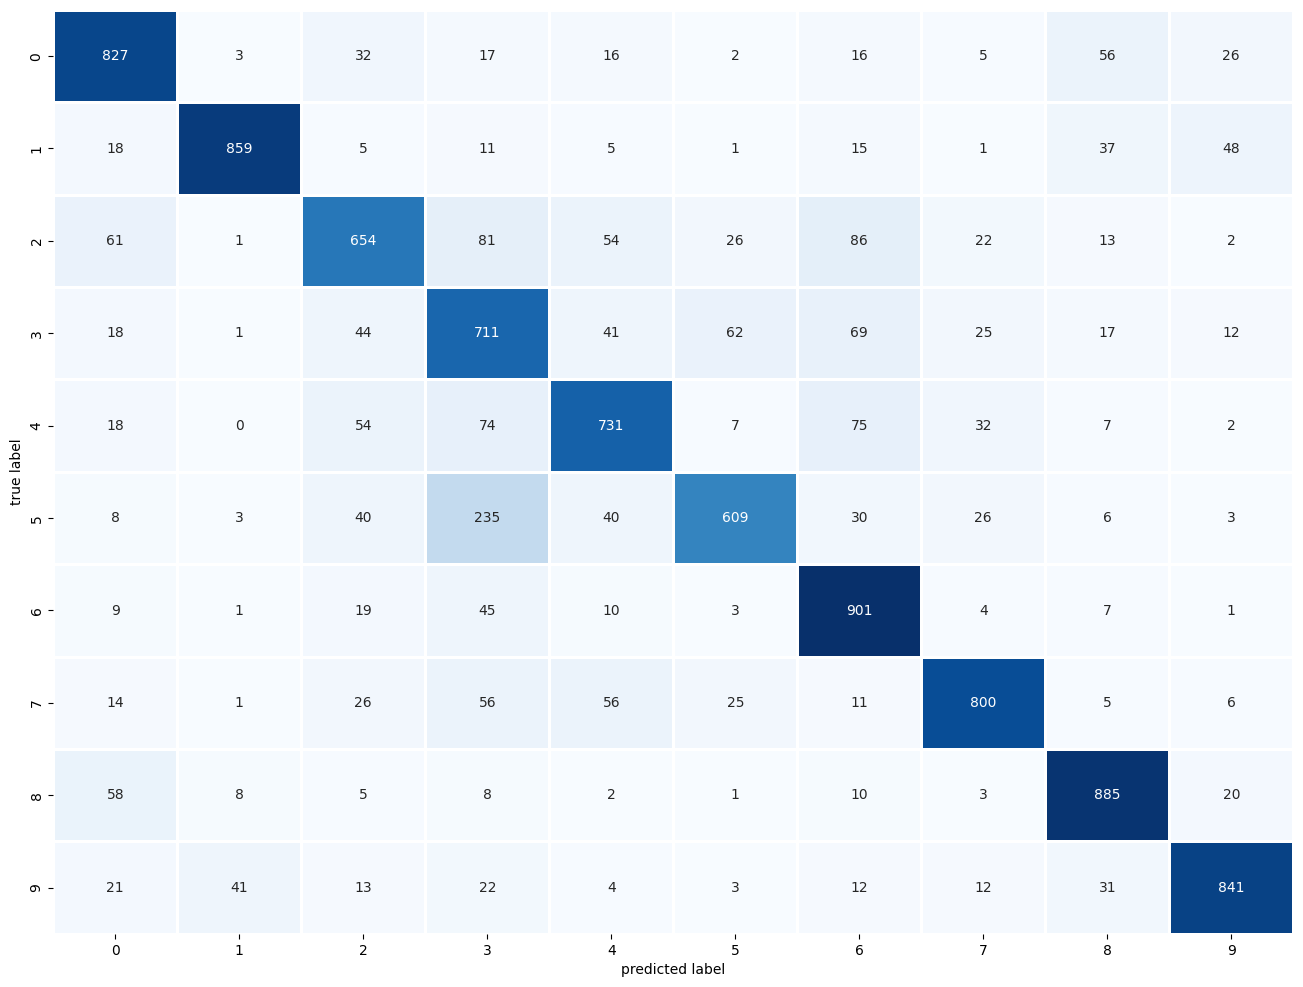

In [ ]:
plot_confusion_matrix(y_test,pred1)

## Load HDF5 Model Format

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('CNN_model.h5')

In [ ]:
preds = model.predict(x_test_norm)

313/313 [==============================] - 1s 3ms/step


In [ ]:
preds.shape

(10000, 10)

## Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane'
                                          ,'automobile'
                                          ,'bird'
                                          ,'cat'
                                          ,'deer'
                                          ,'dog'
                                          ,'frog'
                                          ,'horse'
                                          ,'ship'
                                          ,'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
0,0.10%,0.01%,0.27%,96.79%,0.47%,1.14%,0.86%,0.13%,0.21%,0.01%
1,2.25%,1.12%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,96.25%,0.37%
2,13.21%,13.86%,0.47%,0.79%,0.42%,0.33%,0.29%,0.44%,66.74%,3.45%
3,97.70%,0.08%,0.29%,0.04%,0.09%,0.01%,0.02%,0.02%,1.71%,0.04%
4,0.00%,0.00%,0.09%,0.13%,0.65%,0.01%,99.11%,0.00%,0.00%,0.00%
5,0.00%,0.00%,0.01%,0.66%,0.00%,0.02%,99.30%,0.00%,0.00%,0.00%
6,0.01%,78.07%,0.00%,0.01%,0.00%,0.01%,0.00%,0.01%,0.00%,21.89%
7,1.21%,0.07%,31.15%,4.71%,5.00%,0.90%,56.37%,0.33%,0.19%,0.08%
8,0.01%,0.00%,0.32%,95.27%,0.77%,1.30%,2.17%,0.15%,0.00%,0.00%
9,8.29%,67.91%,0.68%,0.19%,0.56%,0.07%,2.72%,0.09%,2.09%,17.40%


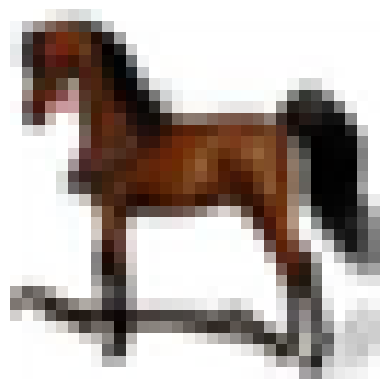

In [ ]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2004]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog'
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 418ms/step


8

In [ ]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

layer_names

['conv2d',
 'max_pooling2d',
 'dropout',
 'conv2d_1',
 'max_pooling2d_1',
 'dropout_1',
 'conv2d_2',
 'max_pooling2d_2',
 'dropout_2',
 'flatten',
 'dense',
 'batch_normalization',
 'dropout_3',
 'dense_1']

<ipython-input-40-1efdfb529874>:28: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-40-1efdfb529874>:31: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


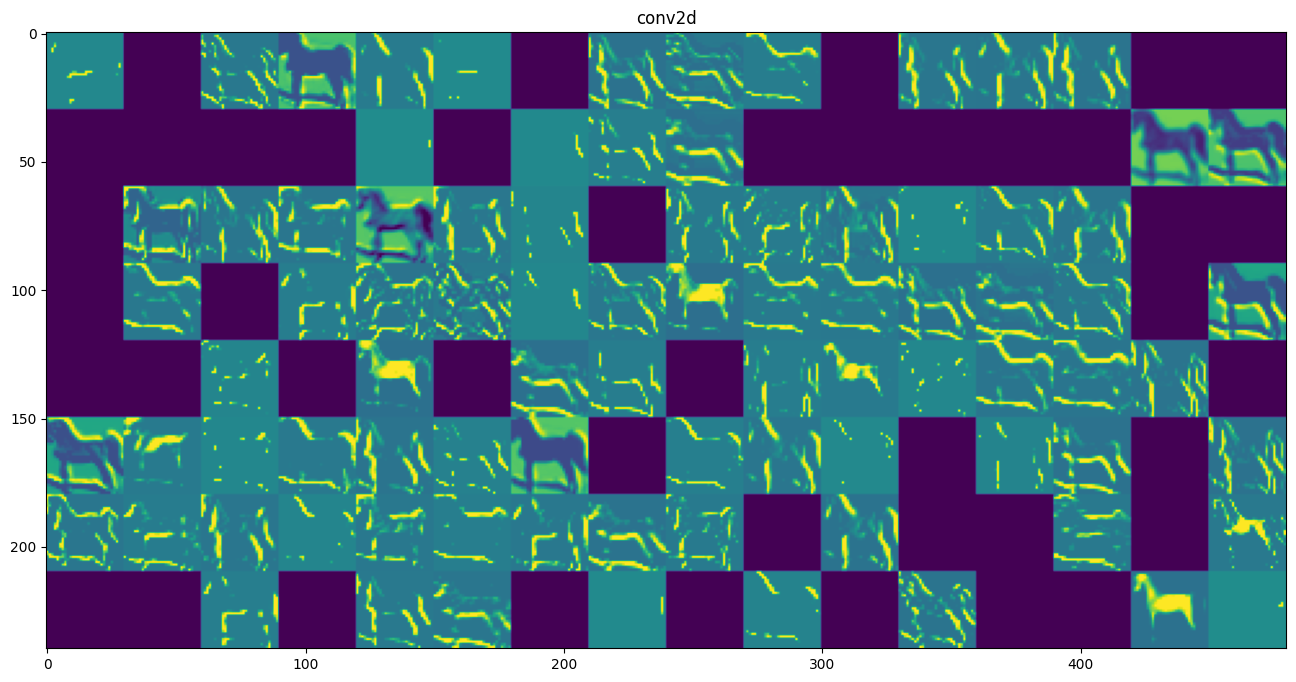

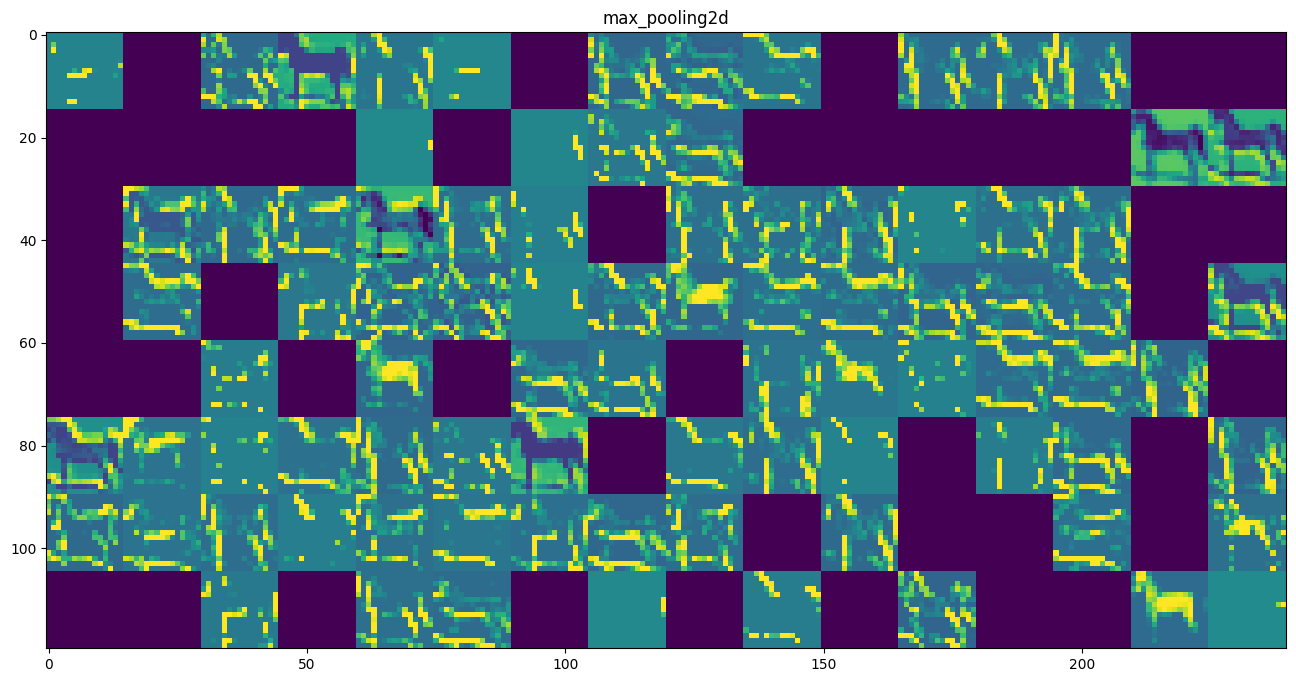

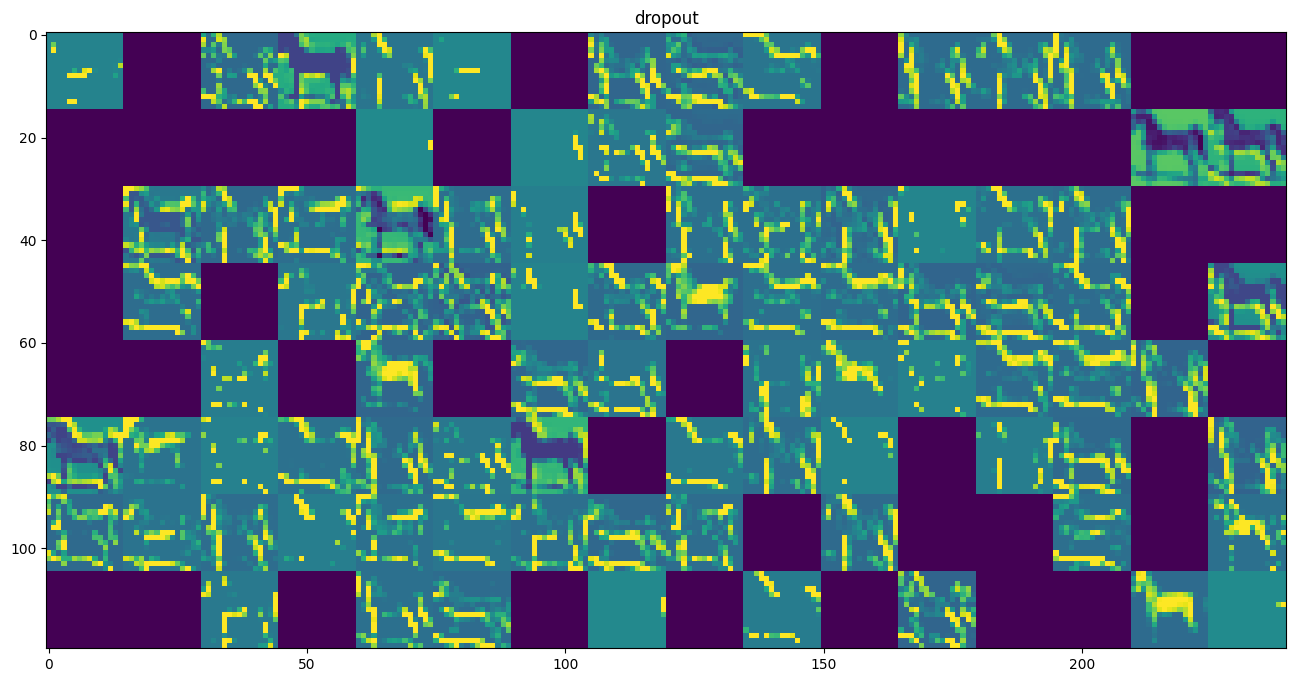

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show();

In [ ]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)

Last Run: 2024-04-19 20:02:22


#Experiment 1: DNN with 2 layers (no regularization)

In [ ]:
#adjust lables to 1D arrays
y_train_1d = to_categorical(y_train_split)
y_valid_1d = to_categorical(y_valid_split)
y_test_1d = to_categorical(y_test)
print(y_train_1d.shape, y_valid_1d.shape, y_test_1d.shape)

(45000, 10) (5000, 10) (10000, 10)


In [ ]:
#Flatten the images from a 2D format  to a 1D format and create the  DNN model
model1 = Sequential([
    Flatten(input_shape = [32,32,3], name = 'input'),
    Dense(units = 256, activation = tf.nn.relu),
    Dense(units = 64, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               786688    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 803786 (3.07 MB)
Trainable params: 803786 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
#train the model and capture processign time
start_time = time.time()
history1 = model1.fit(x_train_norm,
                    y_train_1d,
                    epochs=100,
                    validation_data=(x_valid_norm, y_valid_1d),
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('DNN_model.h5', save_best_only=True, save_weights_only=False),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end_time = time.time()


Epoch 1/100
1407/1407 [==============================] - 9s 5ms/step - loss: 1.9590 - accuracy: 0.2932 - val_loss: 1.8659 - val_accuracy: 0.3148
Epoch 2/100
  47/1407 [>.............................] - ETA: 4s - loss: 1.8084 - accuracy: 0.3431

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 5s 3ms/step - loss: 1.7552 - accuracy: 0.3688 - val_loss: 1.9027 - val_accuracy: 0.3214
Epoch 3/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.6874 - accuracy: 0.3974 - val_loss: 1.7726 - val_accuracy: 0.3652
Epoch 4/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.6373 - accuracy: 0.4170 - val_loss: 1.8583 - val_accuracy: 0.3554
Epoch 5/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.5981 - accuracy: 0.4304 - val_loss: 1.6765 - val_accuracy: 0.4014
Epoch 6/100
1407/1407 [==============================] - 5s 3ms/step - loss: 1.5643 - accuracy: 0.4455 - val_loss: 1.6956 - val_accuracy: 0.4040
Epoch 7/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.5431 - accuracy: 0.4519 - val_loss: 1.6486 - val_accuracy: 0.4096
Epoch 8/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.5251 - accuracy: 0.4582 - val_loss: 1.7494 - val_accuracy: 0.38

In [ ]:
#evaluate the model
model1 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test accuracy: {model1.evaluate(x_test_norm, y_test_1d)[1]:.3f}")

# Get training and validation accuracy from history1
#training_accuracy = history1.history['accuracy']
#validation_accuracy = history1.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy[-1]:.3f}")

# Processing time
processing_time = end_time - start_time
print(f'Model training time: {processing_time:.3f} seconds')

313/313 [==============================] - 2s 6ms/step - loss: 1.5978 - accuracy: 0.4356
Test accuracy: 0.436
Training accuracy: 0.478
Validation accuracy: 0.394
Model training time: 72.246 seconds


In [ ]:
preds1 = model1.predict(x_test_norm)
print('shape_preds: ', preds1.shape)

313/313 [==============================] - 2s 5ms/step
shape_preds:  (10000, 10)


<ipython-input-6-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


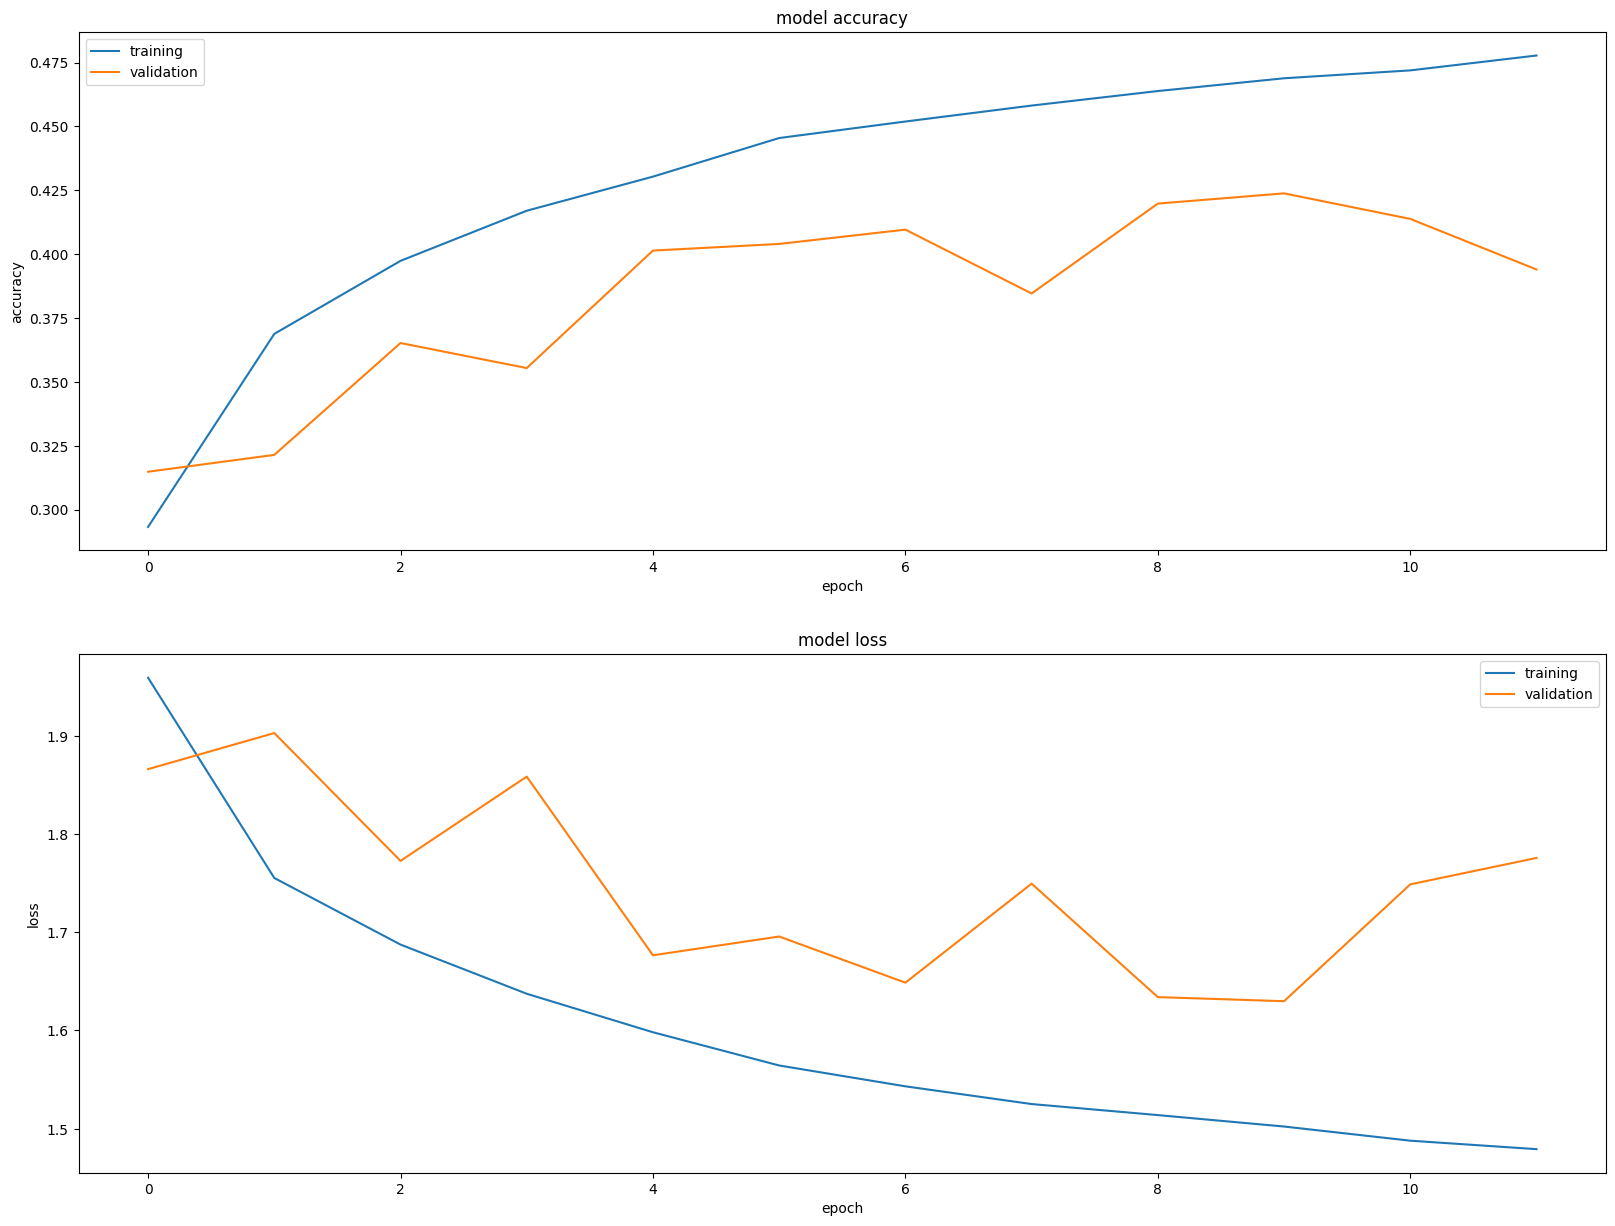

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history1.history['accuracy'], history1.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history1.history['loss'], history1.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 4ms/step


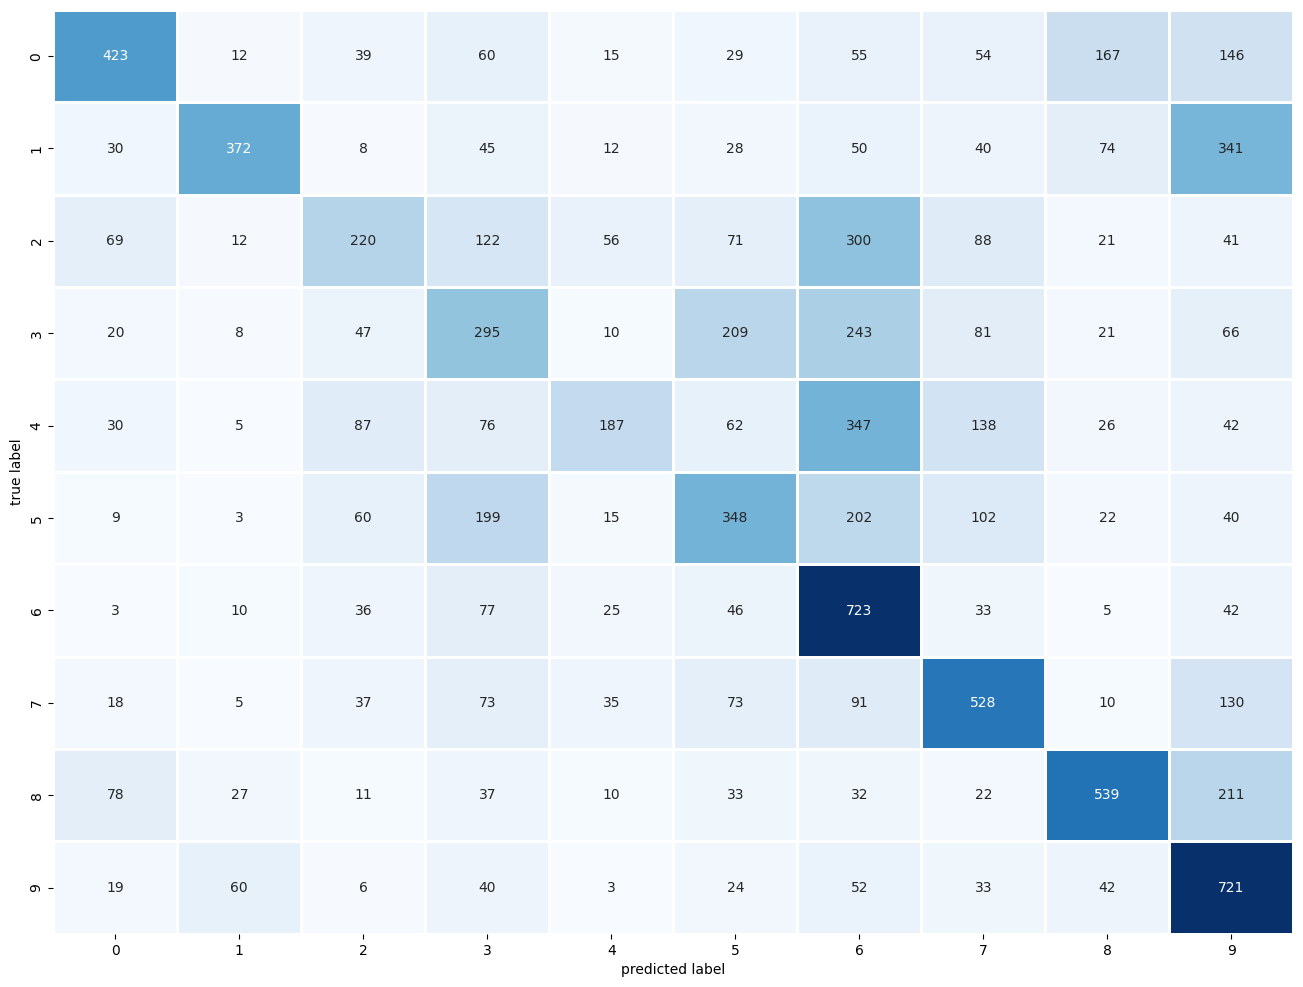

In [ ]:
#Confusion Matrix
pred1 = model1.predict(x_test_norm)
pred1 = np.argmax(pred1, axis=1)

plot_confusion_matrix(y_test, pred1)

#Experiment 2 DNN with 3 layers (no regularization)

In [ ]:
#Flatten the images from a 2D format  to a 1D format and create the  DNN model
model2 = Sequential([
    Flatten(input_shape = [32,32,3], name = 'input'),
    Dense(units = 256, activation = tf.nn.relu),
    Dense(units = 128, activation = tf.nn.relu),
    Dense(units = 64, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 828490 (3.16 MB)
Trainable params: 828490 (3.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
#train the model and capture processign time
start_time = time.time()
history2 = model2.fit(x_train_norm,
                    y_train_1d,
                    epochs=100,
                    validation_data=(x_valid_norm, y_valid_1d),
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('DNN_model.h5', save_best_only=True, save_weights_only=False),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end_time = time.time()

Epoch 1/100
1407/1407 [==============================] - 8s 4ms/step - loss: 1.9389 - accuracy: 0.2979 - val_loss: 1.8103 - val_accuracy: 0.3416
Epoch 2/100
  18/1407 [..............................] - ETA: 8s - loss: 1.7701 - accuracy: 0.3385

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 6s 4ms/step - loss: 1.7452 - accuracy: 0.3721 - val_loss: 1.8141 - val_accuracy: 0.3504
Epoch 3/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.6631 - accuracy: 0.4050 - val_loss: 1.8063 - val_accuracy: 0.3674
Epoch 4/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.6114 - accuracy: 0.4270 - val_loss: 1.7978 - val_accuracy: 0.3850
Epoch 5/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.5730 - accuracy: 0.4404 - val_loss: 1.6474 - val_accuracy: 0.4160
Epoch 6/100
1407/1407 [==============================] - 6s 4ms/step - loss: 1.5531 - accuracy: 0.4506 - val_loss: 1.9454 - val_accuracy: 0.3694
Epoch 7/100
1407/1407 [==============================] - 5s 4ms/step - loss: 1.5323 - accuracy: 0.4586 - val_loss: 1.6848 - val_accuracy: 0.4114


In [ ]:
#evaluate the model
model2 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test accuracy: {model2.evaluate(x_test_norm, y_test_1d)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy[-1]:.3f}")

# Processing time
processing_time = end_time - start_time
print(f'Model training time: {processing_time:.3f} seconds')

313/313 [==============================] - 2s 5ms/step - loss: 1.6132 - accuracy: 0.4299
Test accuracy: 0.430
Training accuracy: 0.459
Validation accuracy: 0.411
Model training time: 46.897 seconds


<ipython-input-19-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


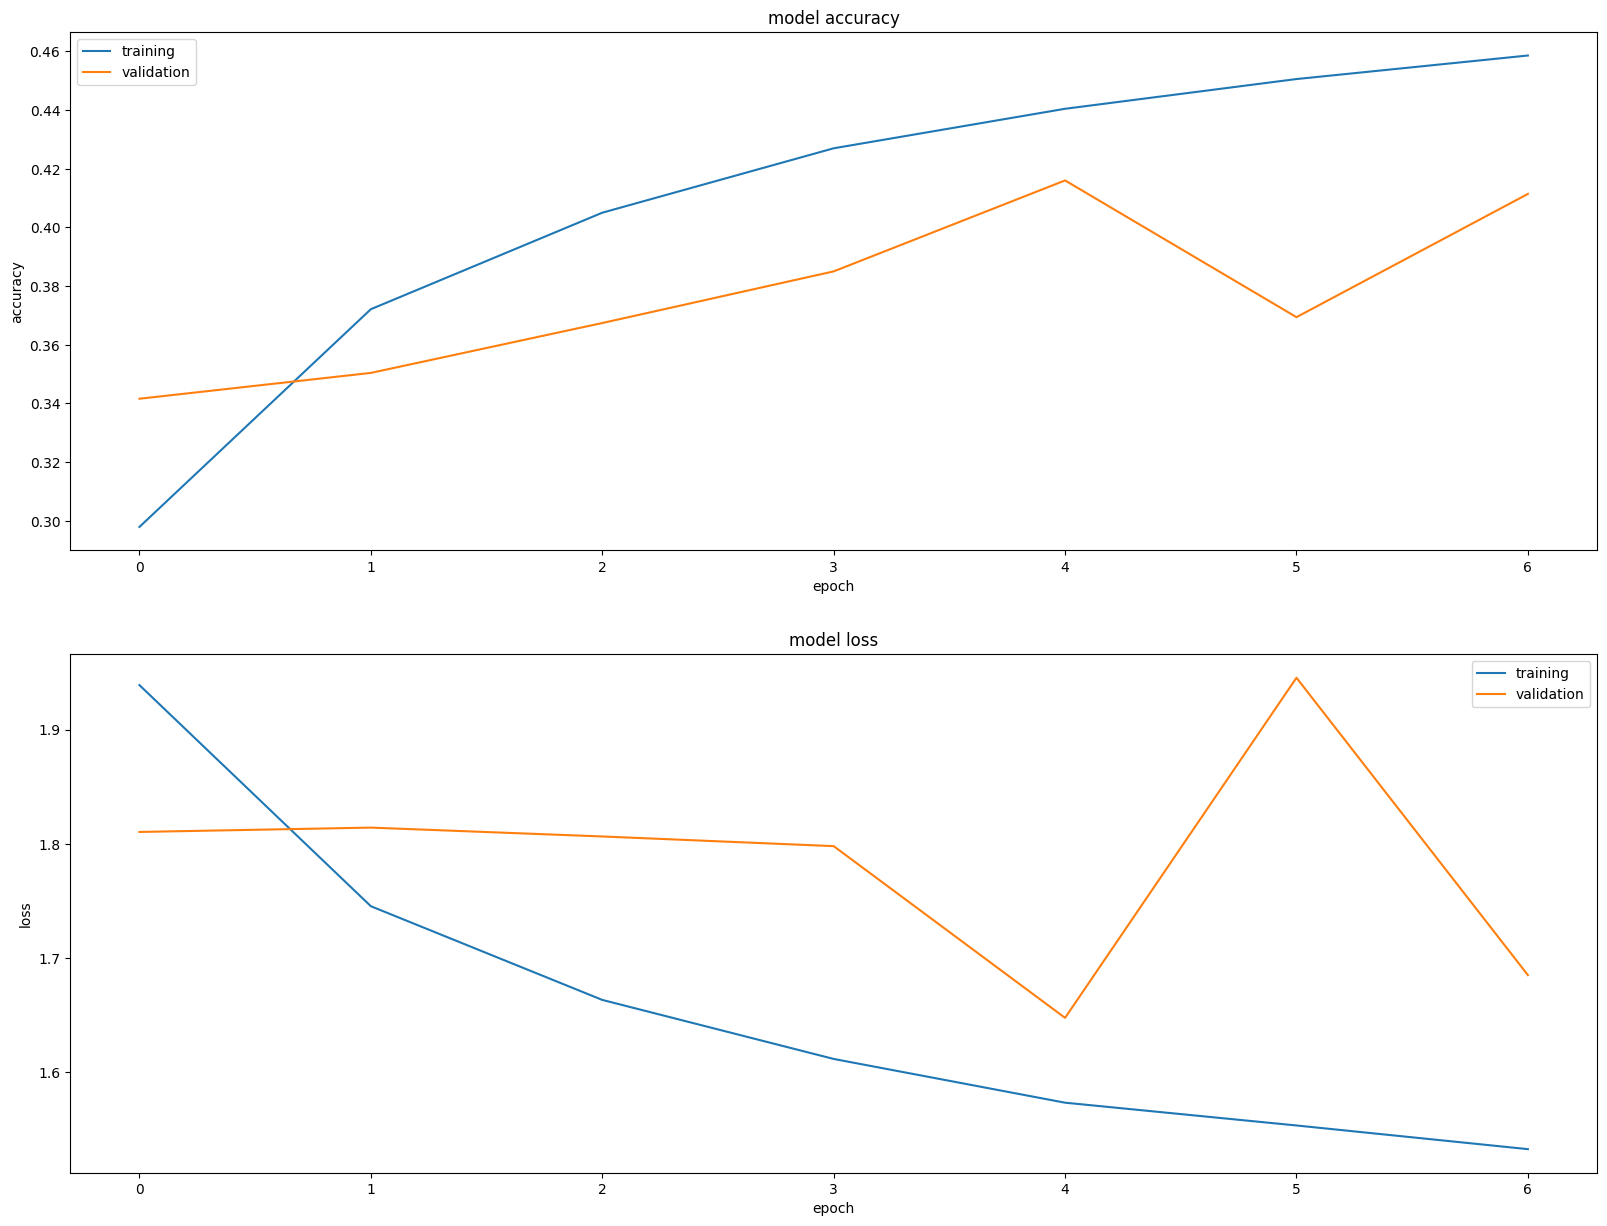

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history2.history['accuracy'], history2.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 3ms/step


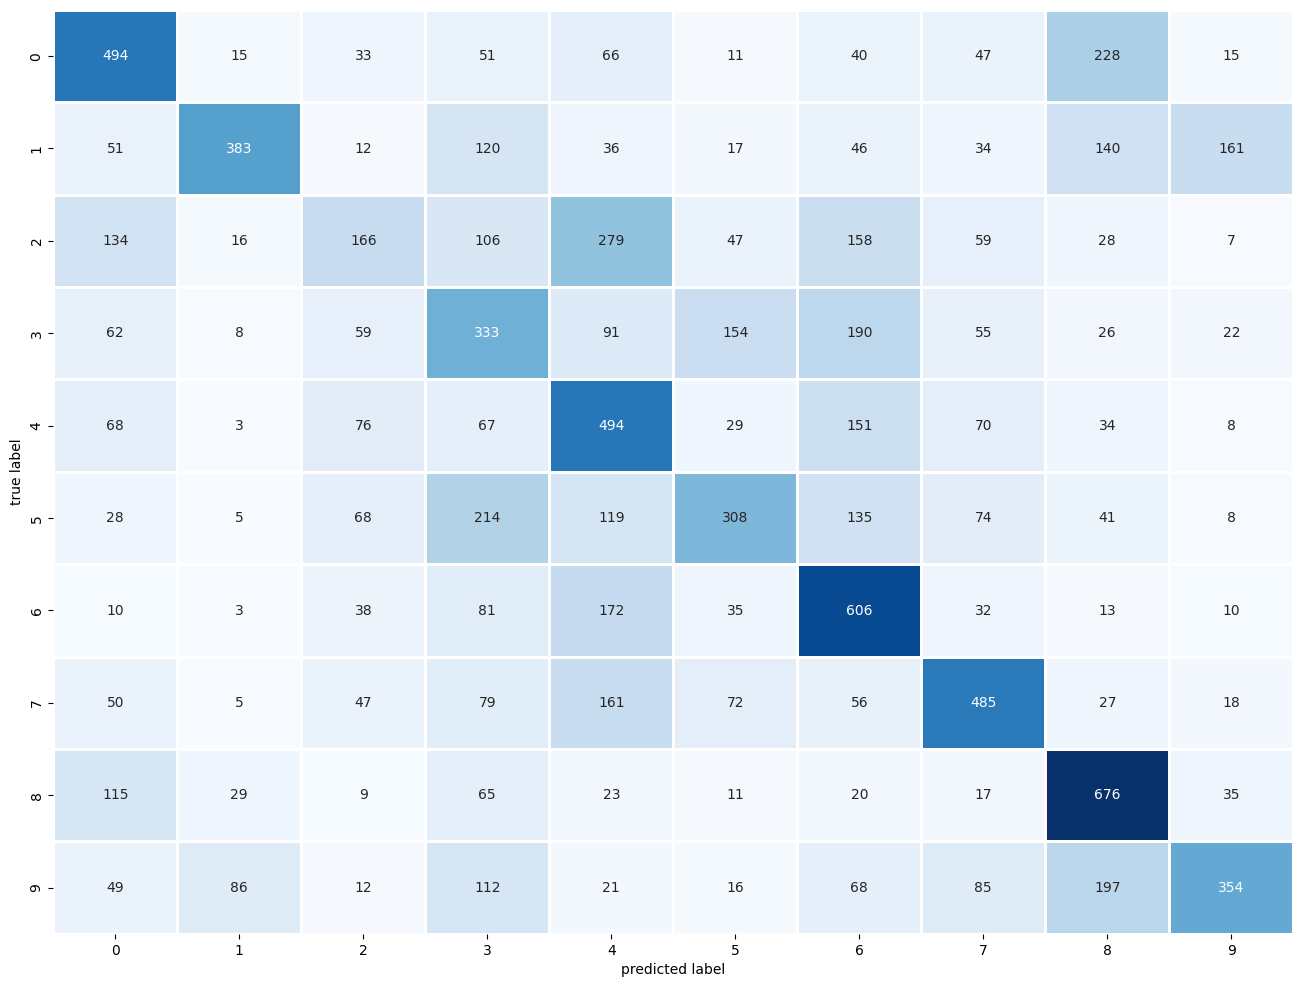

In [ ]:
#Confusion Matrix
pred2 = model2.predict(x_test_norm)
pred2 = np.argmax(pred2, axis=1)

plot_confusion_matrix(y_test, pred2)

#Experiment 3 CNN with 2 layers (no regularization)

In [ ]:
model3 = Sequential([
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Flatten(),
    Dense(units=256, activation=tf.nn.relu),
    Dense(units=256, activation=tf.nn.relu),
    Dense(units=10, activation=tf.nn.softmax)
])


In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 512)       1180160   
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 6, 6, 512)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_9 (Dense)             (None, 256)              

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
start_time3 = time.time()
history3 = model3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=30
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time3 = time.time()

Epoch 1/30
704/704 [==============================] - 19s 21ms/step - loss: 1.4473 - accuracy: 0.4740 - val_loss: 1.1745 - val_accuracy: 0.5800
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


704/704 [==============================] - 14s 19ms/step - loss: 1.0272 - accuracy: 0.6383 - val_loss: 0.9681 - val_accuracy: 0.6568
Epoch 3/30
704/704 [==============================] - 14s 19ms/step - loss: 0.8464 - accuracy: 0.7060 - val_loss: 0.8916 - val_accuracy: 0.6834
Epoch 4/30
704/704 [==============================] - 14s 19ms/step - loss: 0.7090 - accuracy: 0.7527 - val_loss: 0.8410 - val_accuracy: 0.7102
Epoch 5/30
704/704 [==============================] - 13s 19ms/step - loss: 0.5808 - accuracy: 0.7959 - val_loss: 0.8826 - val_accuracy: 0.7124
Epoch 6/30
704/704 [==============================] - 13s 19ms/step - loss: 0.4690 - accuracy: 0.8334 - val_loss: 0.9022 - val_accuracy: 0.7138
Epoch 7/30
704/704 [==============================] - 13s 19ms/step - loss: 0.3664 - accuracy: 0.8700 - val_loss: 0.9767 - val_accuracy: 0.7090
Epoch 8/30
704/704 [==============================] - 14s 19ms/step - loss: 0.2831 - accuracy: 0.8994 - val_loss: 1.0908 - val_accuracy: 0.7152
Epo

In [ ]:
#evaluate the model
model3 = tf.keras.models.load_model("CNN_model.h5")
print(f"Test accuracy: {model3.evaluate(x_test_norm, y_test)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy3 = history3.history['accuracy']
validation_accuracy3 = history3.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy3[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy3[-1]:.3f}")

# Processing time
processing_time3 = end_time3 - start_time3
print(f'Model training time: {processing_time3:.3f} seconds')


313/313 [==============================] - 2s 5ms/step - loss: 0.8613 - accuracy: 0.7064
Test accuracy: 0.706
Training accuracy: 0.959
Validation accuracy: 0.709
Model training time: 181.478 seconds


<ipython-input-4-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


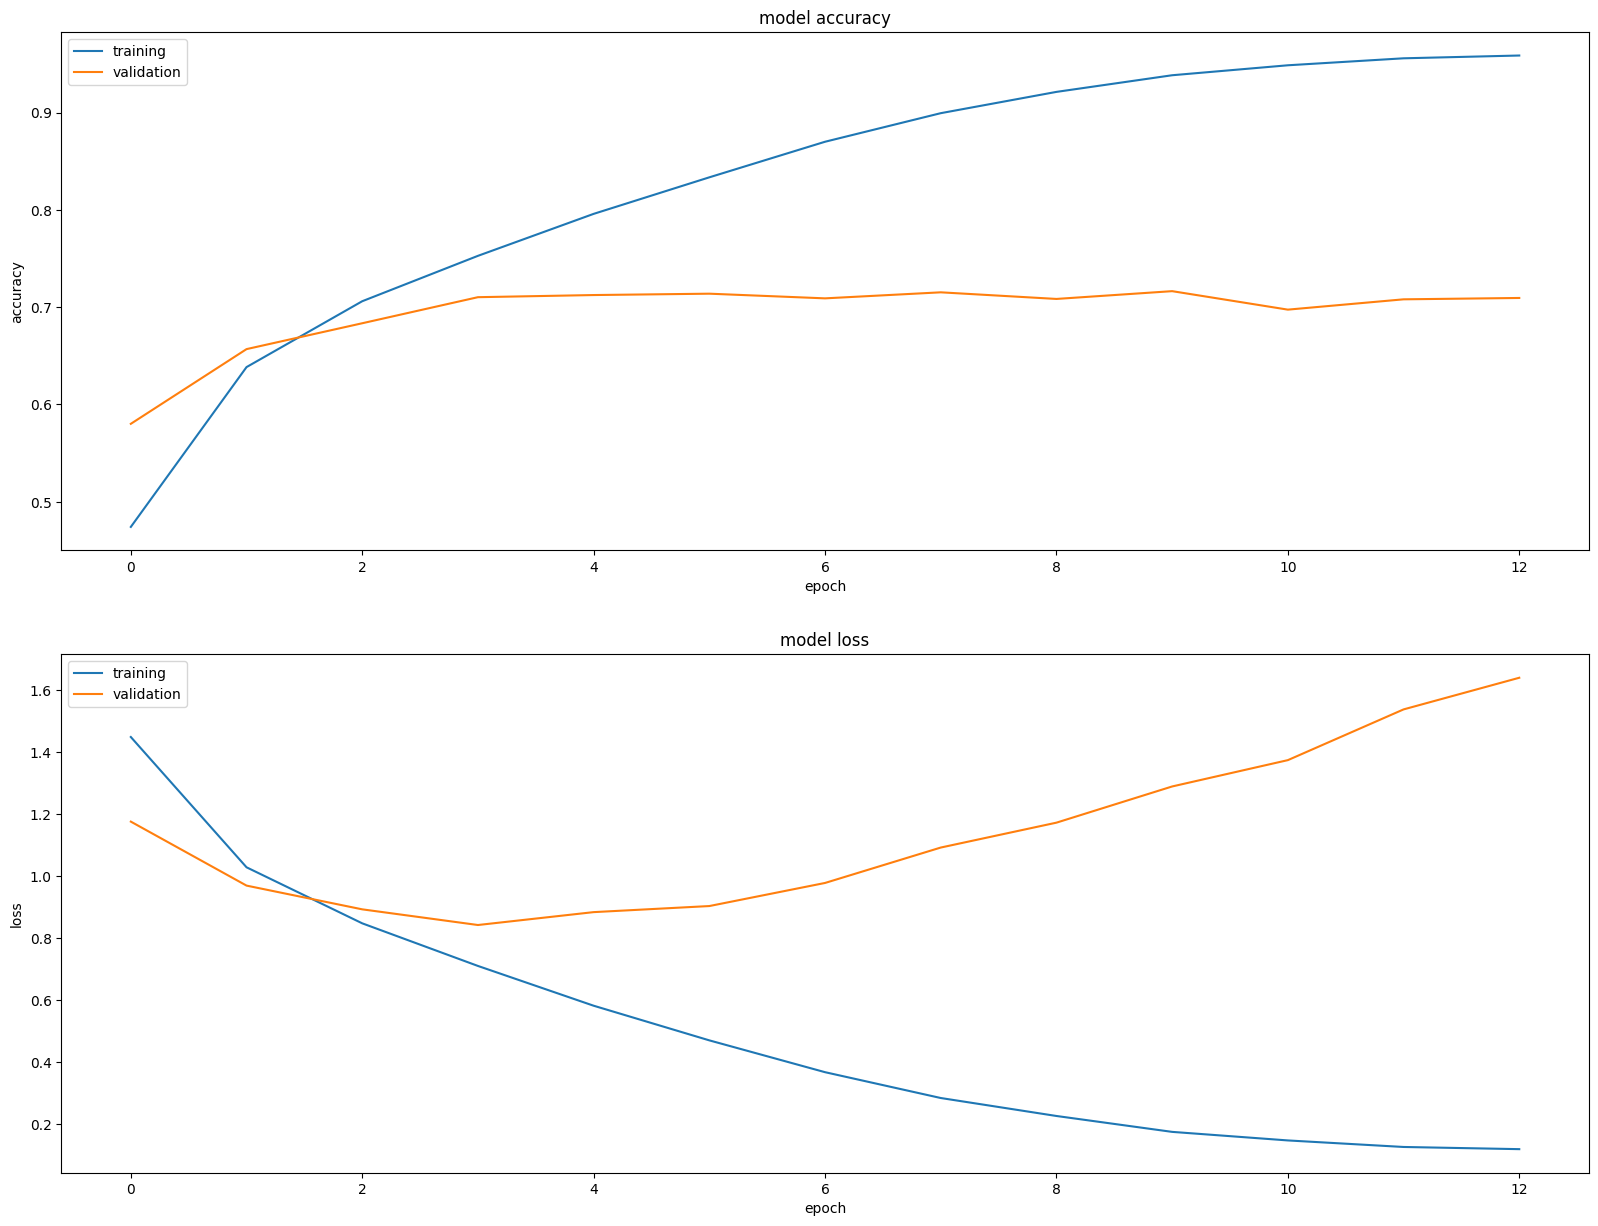

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history3.history['accuracy'], history3.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history3.history['loss'], history3.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 3ms/step


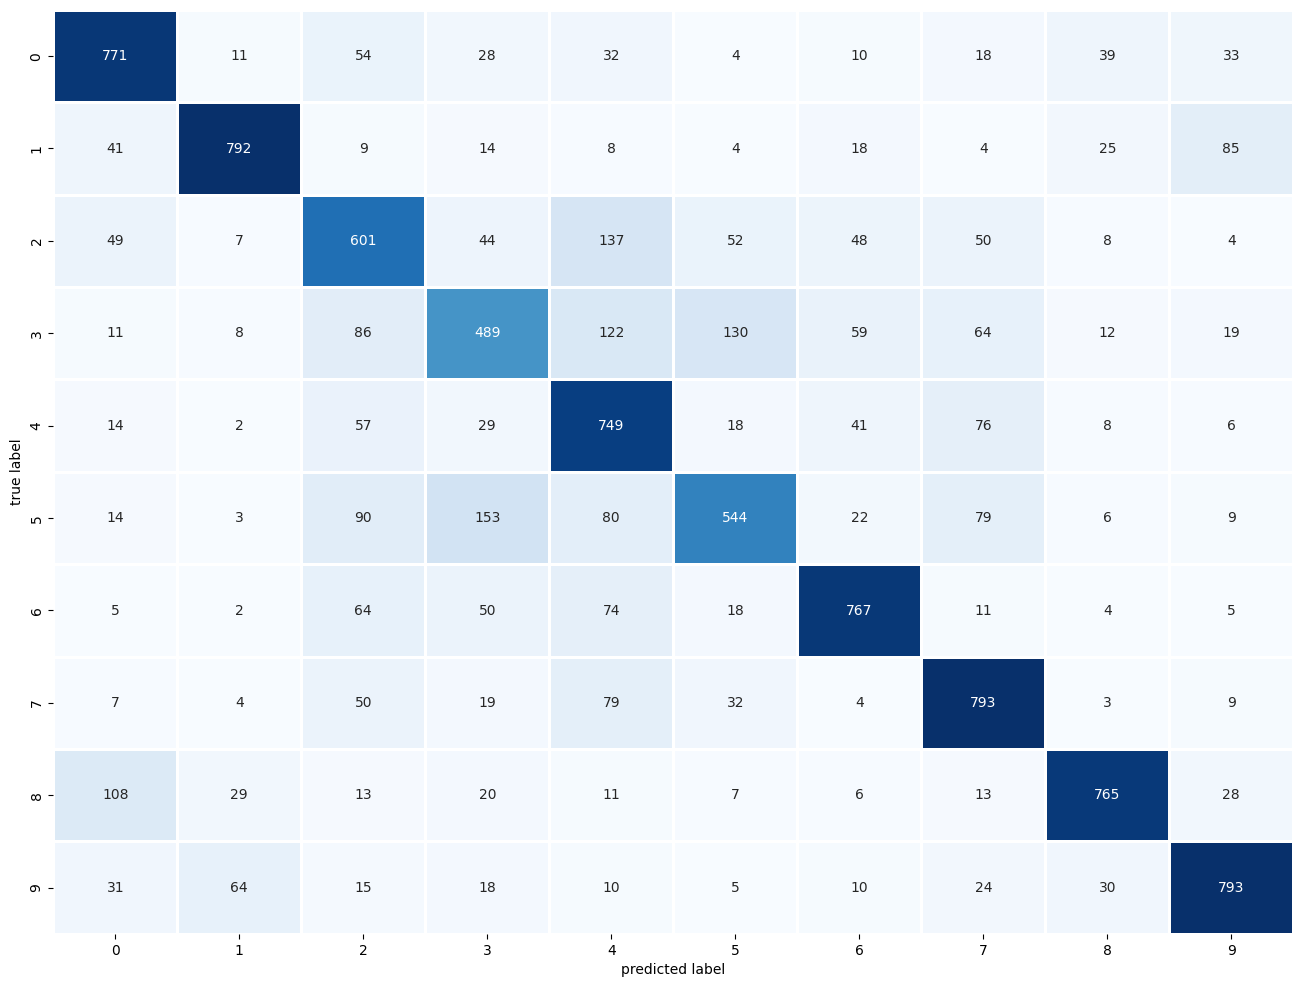

In [ ]:
pred3= model3.predict(x_test_norm)
pred3=np.argmax(pred3, axis=1)

plot_confusion_matrix(y_test, pred3)

#Experiment 4 CNN with 3 layers (no regularization)

In [ ]:
model4 = Sequential([
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Flatten(),
    Dense(units=256, activation=tf.nn.relu),
    Dense(units=256, activation=tf.nn.relu),
    Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 512)       1180160   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 512)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 1024)        4719616   
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 1024)        0

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
start_time4 = time.time()
history4 = model4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time4 = time.time()

Epoch 1/20
88/88 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.7918

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 17s 157ms/step - loss: 0.6073 - accuracy: 0.7918 - val_loss: 0.8570 - val_accuracy: 0.7086
Epoch 2/20
88/88 [==============================] - 14s 155ms/step - loss: 0.5436 - accuracy: 0.8124 - val_loss: 0.7551 - val_accuracy: 0.7374
Epoch 3/20
88/88 [==============================] - 14s 155ms/step - loss: 0.4702 - accuracy: 0.8391 - val_loss: 0.7831 - val_accuracy: 0.7338
Epoch 4/20
88/88 [==============================] - 14s 155ms/step - loss: 0.3929 - accuracy: 0.8641 - val_loss: 0.8282 - val_accuracy: 0.7326
Epoch 5/20
88/88 [==============================] - 14s 156ms/step - loss: 0.3430 - accuracy: 0.8812 - val_loss: 0.8073 - val_accuracy: 0.7394
Epoch 6/20
88/88 [==============================] - 14s 157ms/step - loss: 0.2665 - accuracy: 0.9089 - val_loss: 0.8873 - val_accuracy: 0.7426
Epoch 7/20
88/88 [==============================] - 14s 156ms/step - loss: 0.2223 - accuracy: 0.9234 - val_loss: 0.9044 - val_accuracy: 0.7394
Epoch 8/20

In [ ]:
#evaluate the model
model4 = tf.keras.models.load_model("CNN_model.h5")
print(f"Test accuracy: {model4.evaluate(x_test_norm, y_test)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy4 = history4.history['accuracy']
validation_accuracy4 = history4.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy4[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy4[-1]:.3f}")

# Processing time
processing_time4 = end_time4 - start_time4
print(f'Model training time: {processing_time4:.3f} seconds')

313/313 [==============================] - 2s 7ms/step - loss: 0.7687 - accuracy: 0.7405
Test accuracy: 0.740
Training accuracy: 0.975
Validation accuracy: 0.735
Model training time: 185.619 seconds


<ipython-input-6-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


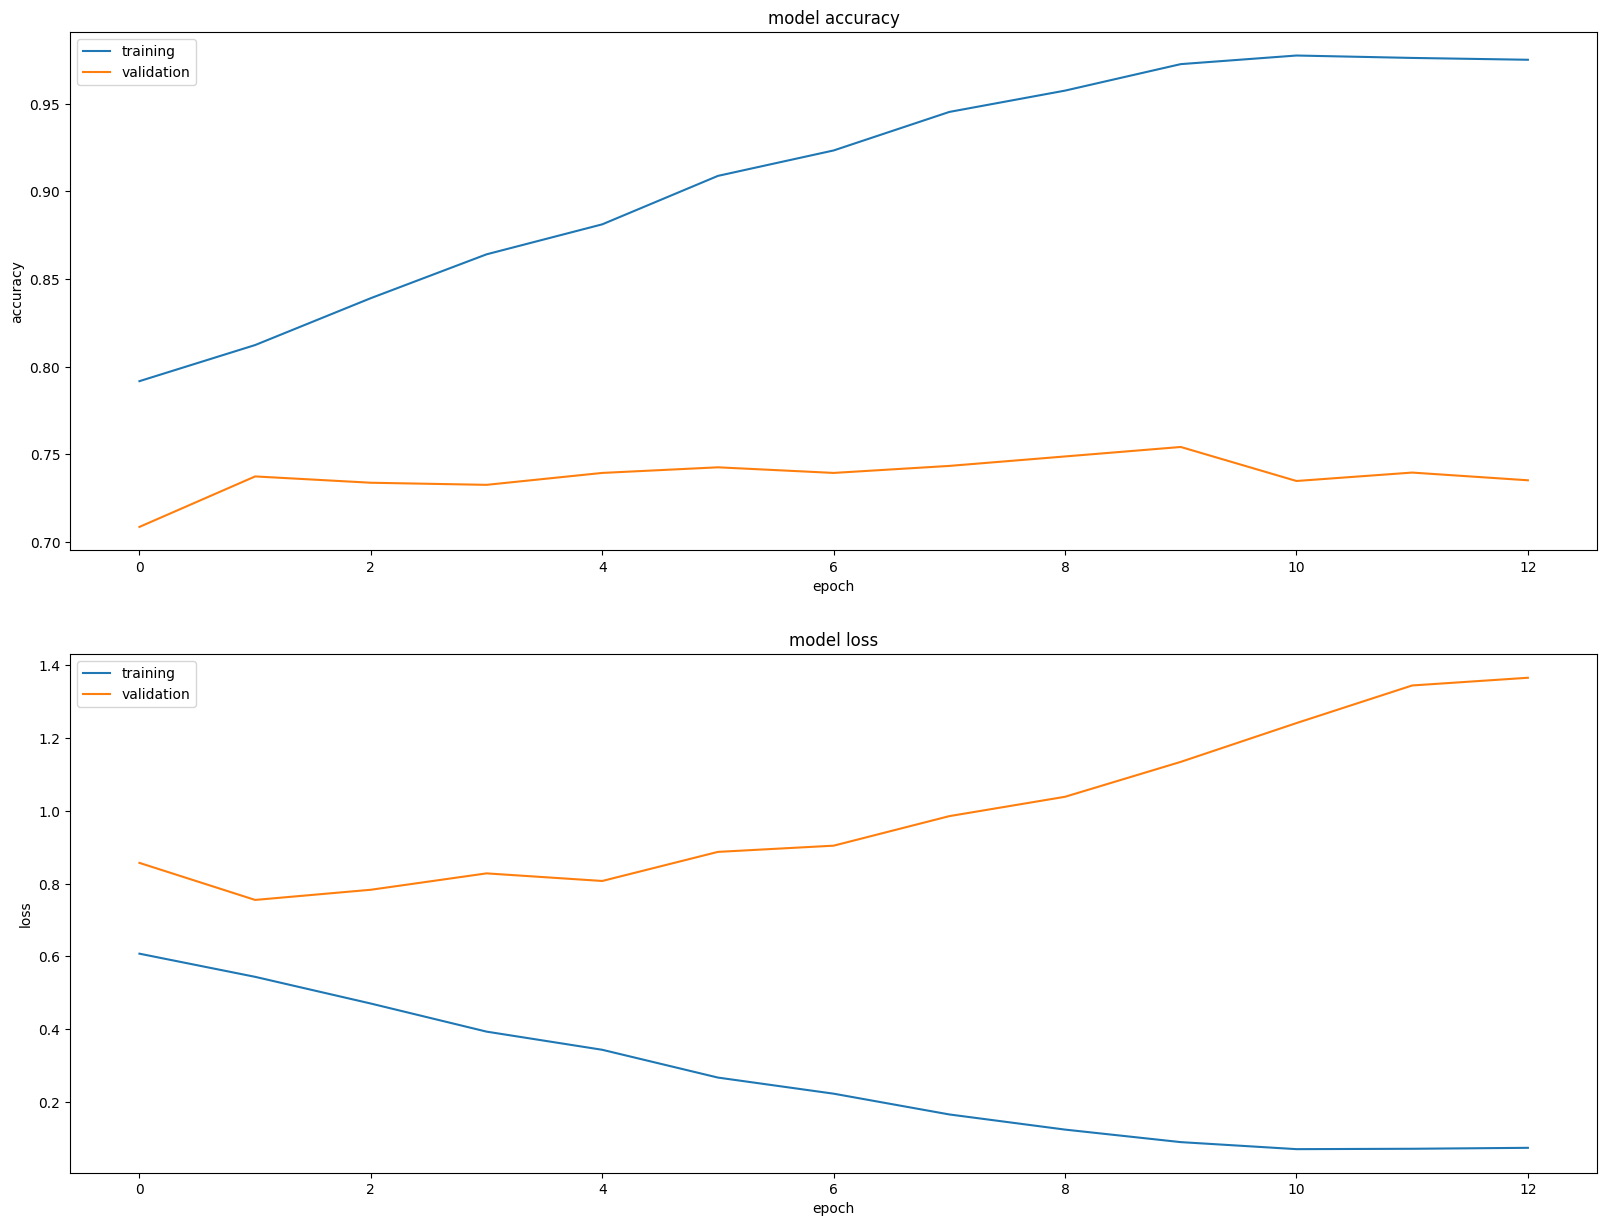

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history4.history['accuracy'], history4.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history4.history['loss'], history4.history['val_loss'], 'loss', 212)

313/313 [==============================] - 2s 5ms/step


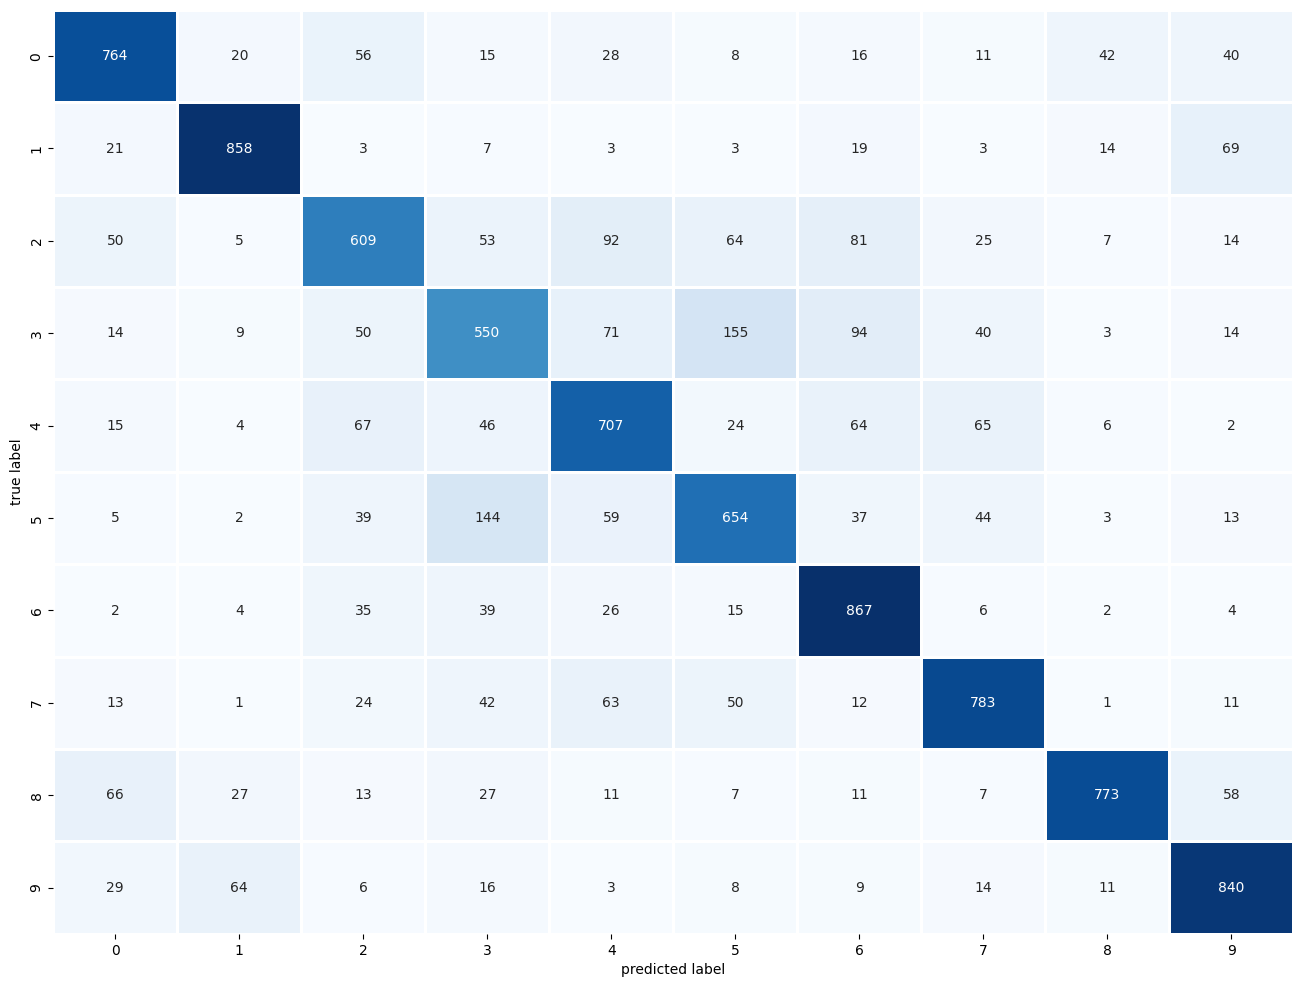

In [ ]:
pred4= model4.predict(x_test_norm)
pred4=np.argmax(pred4, axis=1)

plot_confusion_matrix(y_test, pred4)

#Experiment 5 DNN with 2 layers (L2 regularization)

In [ ]:
#adjust lables to 1D arrays
y_train_1d = to_categorical(y_train_split)
y_valid_1d = to_categorical(y_valid_split)
y_test_1d = to_categorical(y_test)
print(y_train_1d.shape, y_valid_1d.shape, y_test_1d.shape)

(45000, 10) (5000, 10) (10000, 10)


In [ ]:
#Flatten the images from a 2D format  to a 1D format and create the  DNN model
model5 = Sequential([
    Flatten(input_shape = [32,32,3], name = 'input'),
    Dense(units = 256, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(units = 64, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])

In [ ]:
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 256)               786688    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 803786 (3.07 MB)
Trainable params: 803786 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model5.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
#train the model and capture processign time
start_time5 = time.time()
history5 = model5.fit(x_train_norm,
                    y_train_1d,
                    epochs=100,
                    validation_data=(x_valid_norm, y_valid_1d),
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('DNN_model.h5', save_best_only=True, save_weights_only=False),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end_time5 = time.time()

Epoch 1/100
1407/1407 [==============================] - 18s 12ms/step - loss: 2.0583 - accuracy: 0.2924 - val_loss: 2.0358 - val_accuracy: 0.2952
Epoch 2/100
  11/1407 [..............................] - ETA: 15s - loss: 1.9041 - accuracy: 0.3580

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 18s 13ms/step - loss: 1.8451 - accuracy: 0.3572 - val_loss: 1.8886 - val_accuracy: 0.3506
Epoch 3/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.8016 - accuracy: 0.3757 - val_loss: 1.8096 - val_accuracy: 0.3634
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7687 - accuracy: 0.3924 - val_loss: 1.9306 - val_accuracy: 0.3328
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7529 - accuracy: 0.4021 - val_loss: 1.9010 - val_accuracy: 0.3486


In [ ]:
#evaluate the model
model5 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test accuracy: {model5.evaluate(x_test_norm, y_test_1d)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy5 = history5.history['accuracy']
validation_accuracy5 = history5.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy5[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy5[-1]:.3f}")

# Processing time
processing_time5 = end_time5 - start_time5
print(f'Model training time: {processing_time5:.3f} seconds')


313/313 [==============================] - 2s 6ms/step - loss: 1.7970 - accuracy: 0.3743
Test accuracy: 0.374
Training accuracy: 0.402
Validation accuracy: 0.349
Model training time: 89.441 seconds


<ipython-input-6-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


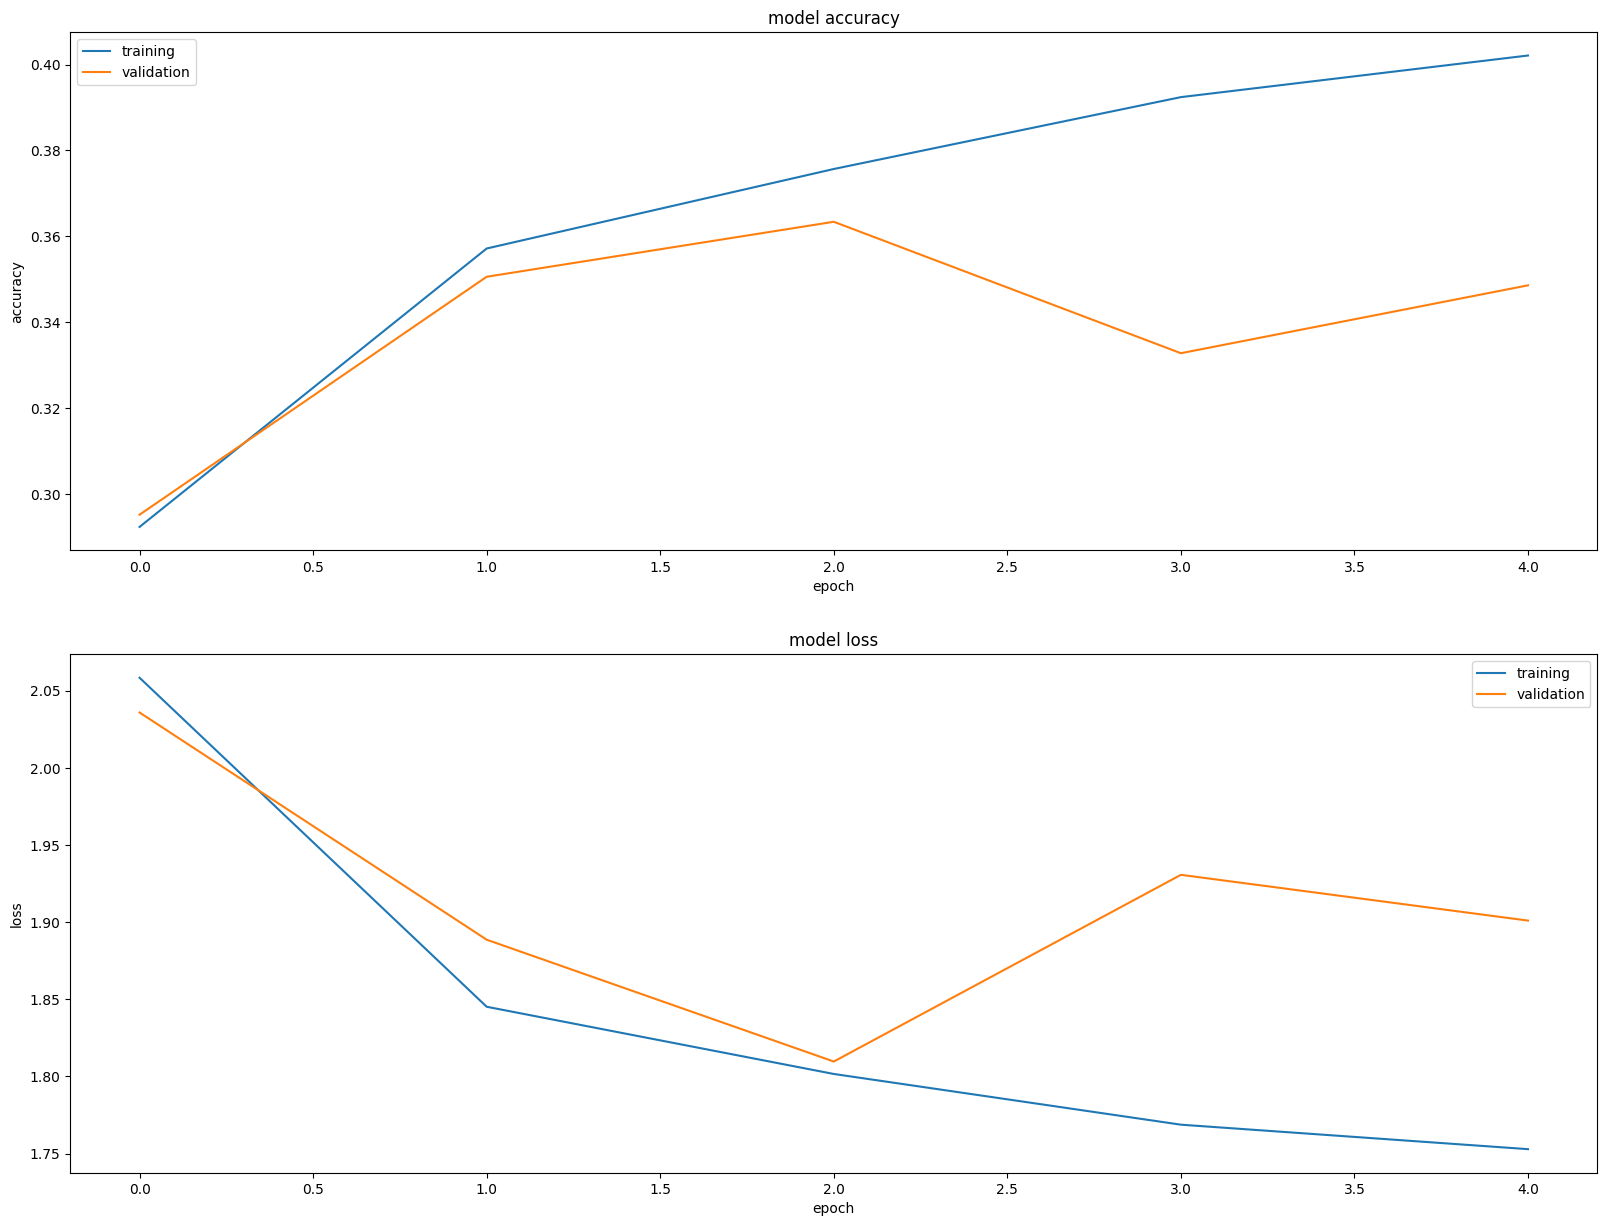

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history5.history['accuracy'], history5.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history5.history['loss'], history5.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 4ms/step


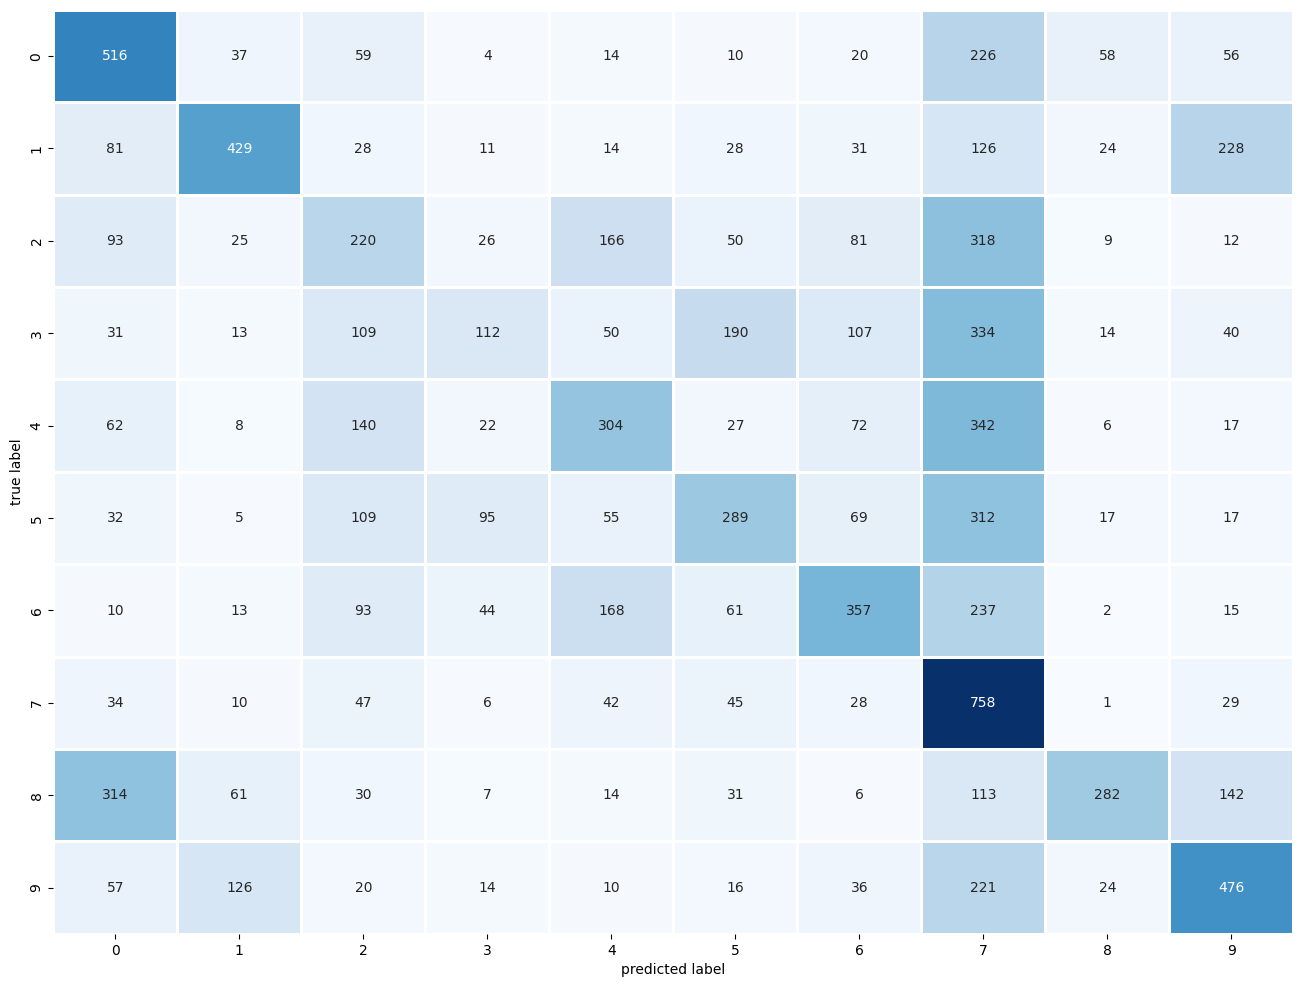

In [ ]:
pred5= model5.predict(x_test_norm)
pred5=np.argmax(pred5, axis=1)

plot_confusion_matrix(y_test, pred5)

#Experiment 6 DNN with 2 layers (L1 regularization)

In [ ]:
#Flatten the images from a 2D format  to a 1D format and create the  DNN model
model6 = Sequential([
    Flatten(input_shape = [32,32,3], name = 'input'),
    Dense(units = 256, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L1(0.001)),
    Dense(units = 64, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])

In [ ]:
model6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               786688    
                                                                 
 dense_5 (Dense)             (None, 64)                16448     
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 803786 (3.07 MB)
Trainable params: 803786 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model6.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
#train the model and capture processign time
start_time6 = time.time()
history6 = model6.fit(x_train_norm,
                    y_train_1d,
                    epochs=100,
                    validation_data=(x_valid_norm, y_valid_1d),
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('DNN_model.h5', save_best_only=True, save_weights_only=False),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end_time6 = time.time()

Epoch 1/100
1407/1407 [==============================] - 19s 13ms/step - loss: 2.9959 - accuracy: 0.1973 - val_loss: 2.4811 - val_accuracy: 0.2540
Epoch 2/100
  11/1407 [..............................] - ETA: 15s - loss: 2.4805 - accuracy: 0.2386

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 20s 14ms/step - loss: 2.4399 - accuracy: 0.2827 - val_loss: 2.3747 - val_accuracy: 0.3092
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 2.4102 - accuracy: 0.3022 - val_loss: 2.4164 - val_accuracy: 0.3042
Epoch 4/100
1407/1407 [==============================] - 19s 13ms/step - loss: 2.3914 - accuracy: 0.3099 - val_loss: 2.3443 - val_accuracy: 0.3354
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 2.3868 - accuracy: 0.3157 - val_loss: 2.3789 - val_accuracy: 0.3222
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 2.3813 - accuracy: 0.3177 - val_loss: 2.3938 - val_accuracy: 0.3054


In [ ]:
#evaluate the model
model6 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test accuracy: {model6.evaluate(x_test_norm, y_test_1d)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy6 = history6.history['accuracy']
validation_accuracy6 = history6.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy6[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy6[-1]:.3f}")

# Processing time
processing_time6 = end_time6 - start_time6
print(f'Model training time: {processing_time6:.3f} seconds')


313/313 [==============================] - 2s 5ms/step - loss: 2.3253 - accuracy: 0.3373
Test accuracy: 0.337
Training accuracy: 0.318
Validation accuracy: 0.305
Model training time: 113.066 seconds


<ipython-input-6-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


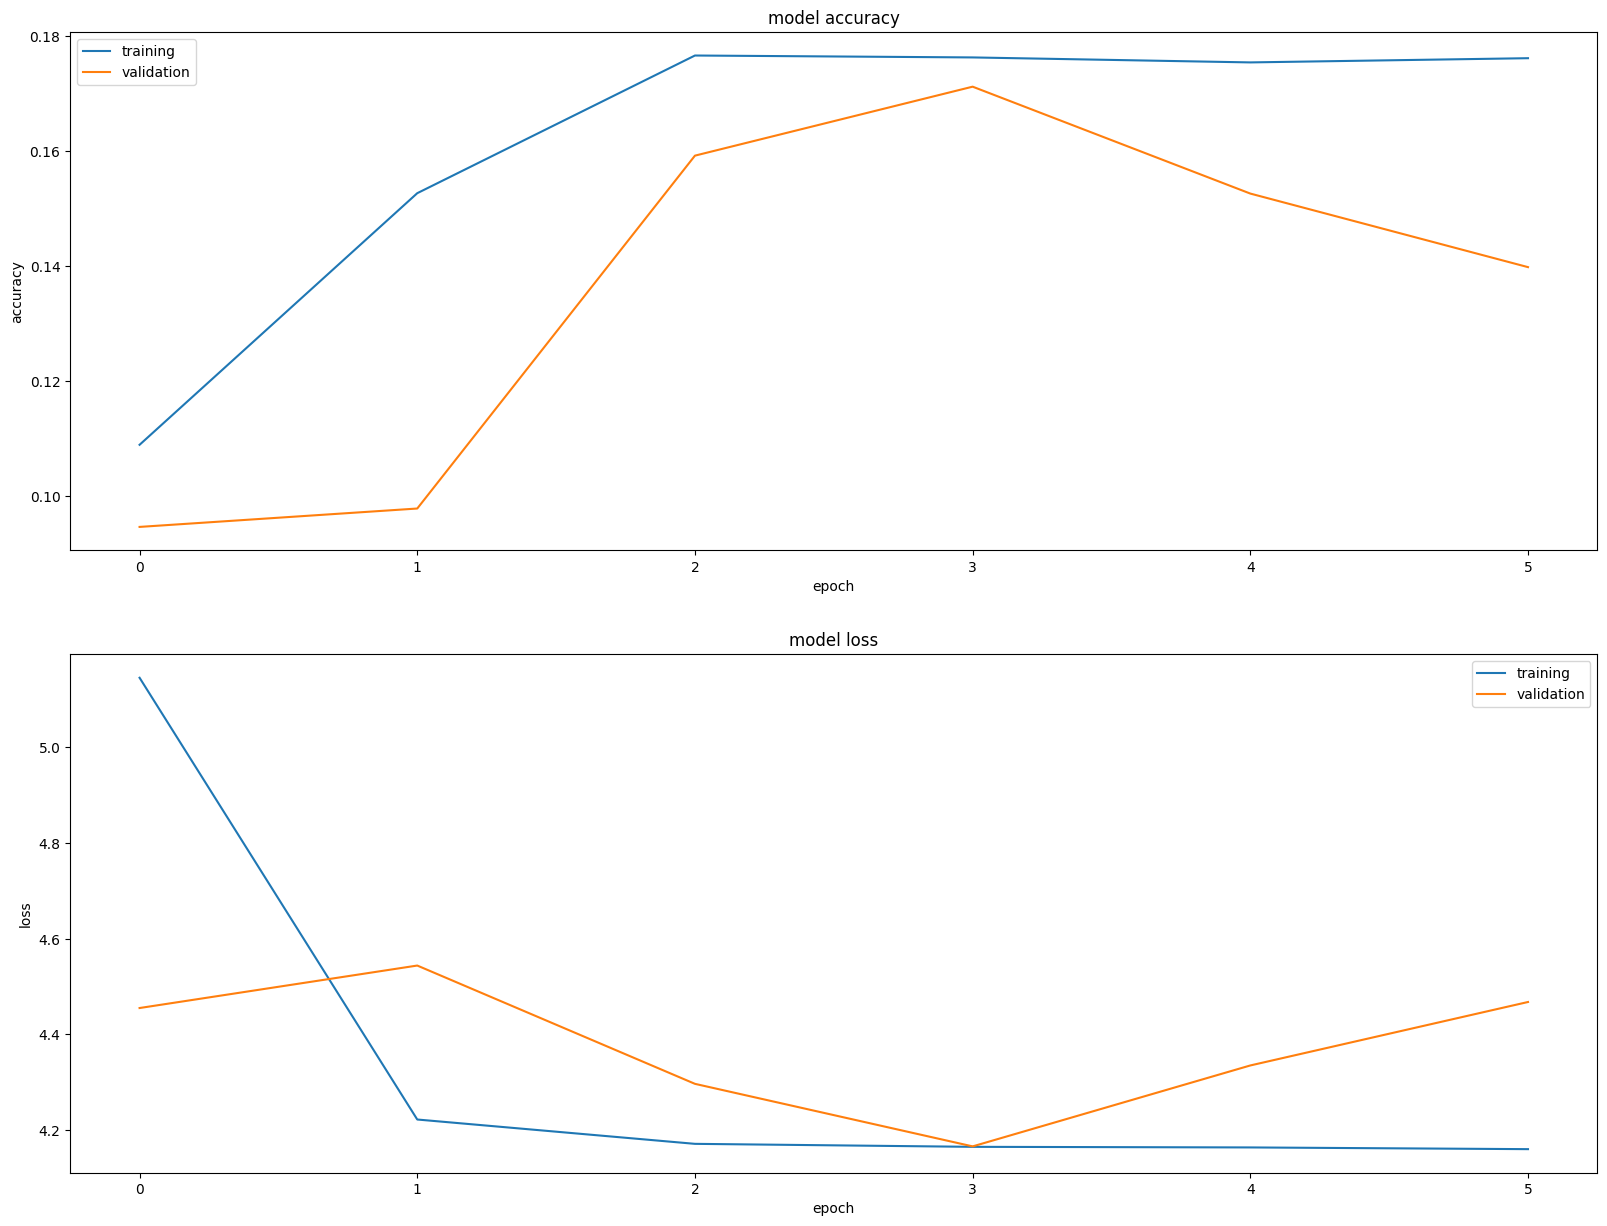

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history6.history['accuracy'], history6.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history6.history['loss'], history6.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 4ms/step


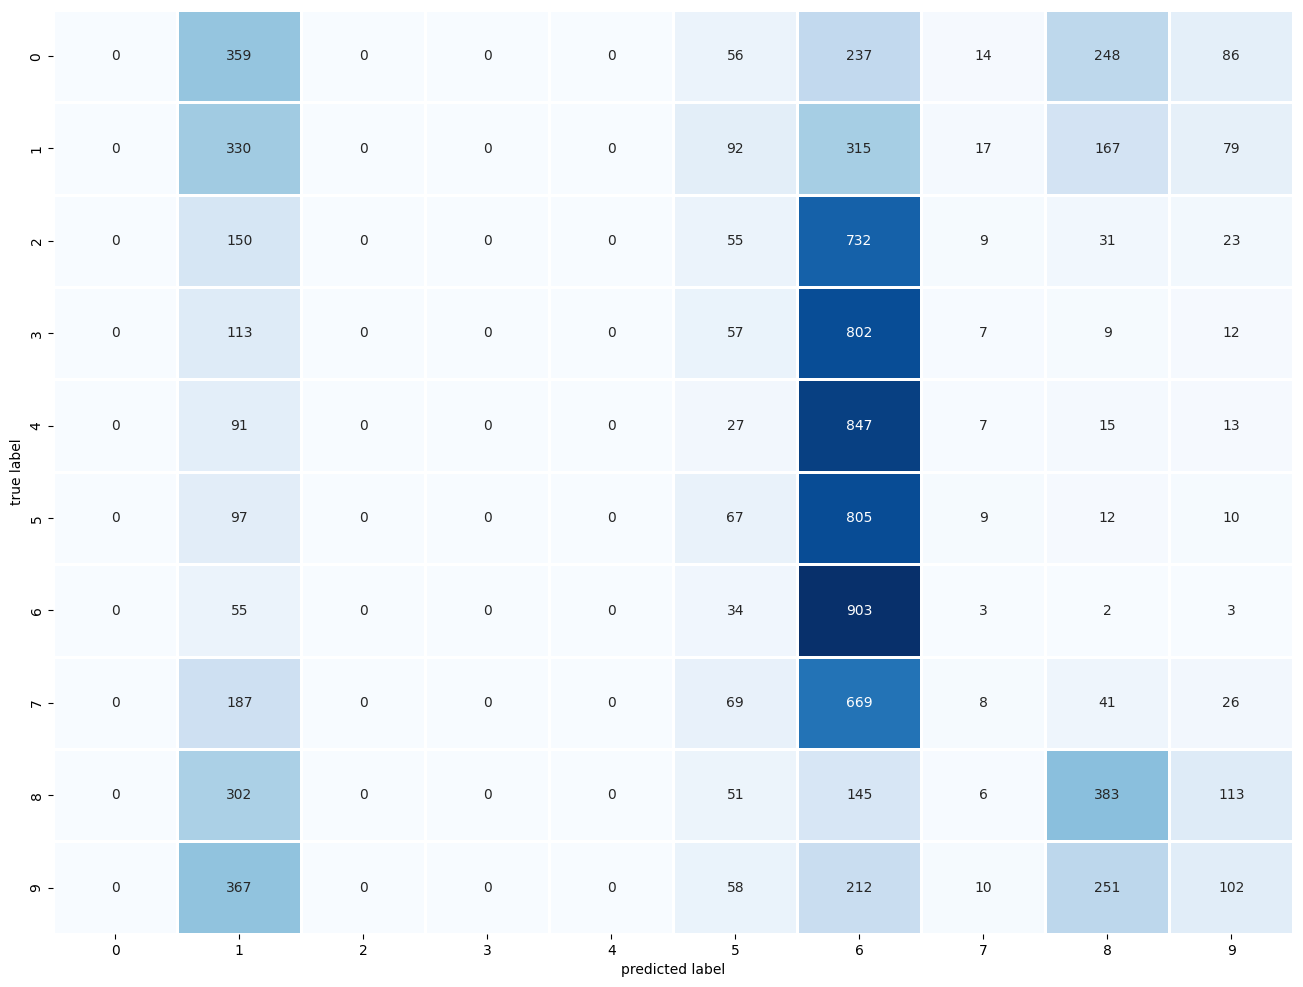

In [ ]:
pred6= model6.predict(x_test_norm)
pred6=np.argmax(pred6, axis=1)

plot_confusion_matrix(y_test, pred6)

#Experiment 7 DNN with 3 layers (L2 regularization)

In [ ]:
#Flatten the images from a 2D format  to a 1D format and create the  DNN model
model7 = Sequential([
    Flatten(input_shape = [32,32,3], name = 'input'),
    Dense(units = 256, activation = tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(units = 128, activation = tf.nn.relu),
    Dense(units = 64, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])

In [ ]:
model7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               786688    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 828490 (3.16 MB)
Trainable params: 828490 (3.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model7.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [ ]:
#train the model and capture processign time
start_time7 = time.time()
history7 = model7.fit(x_train_norm,
                    y_train_1d,
                    epochs=100,
                    validation_data=(x_valid_norm, y_valid_1d),
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('DNN_model.h5', save_best_only=True, save_weights_only=False),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end_time7 = time.time()

Epoch 1/100
1407/1407 [==============================] - 19s 14ms/step - loss: 1.7187 - accuracy: 0.4131 - val_loss: 2.0248 - val_accuracy: 0.3266
Epoch 2/100
  11/1407 [..............................] - ETA: 14s - loss: 1.6402 - accuracy: 0.3920

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 19s 13ms/step - loss: 1.7115 - accuracy: 0.4174 - val_loss: 1.8738 - val_accuracy: 0.3704
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.7107 - accuracy: 0.4173 - val_loss: 1.8030 - val_accuracy: 0.3864
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.7066 - accuracy: 0.4198 - val_loss: 2.1192 - val_accuracy: 0.3368
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.7020 - accuracy: 0.4248 - val_loss: 1.7086 - val_accuracy: 0.4142
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7051 - accuracy: 0.4213 - val_loss: 2.1496 - val_accuracy: 0.3424
Epoch 7/100
1407/1407 [==============================] - 19s 13ms/step - loss: 1.7084 - accuracy: 0.4237 - val_loss: 1.8322 - val_accuracy: 0.3782


In [ ]:
#evaluate the model
model7 = tf.keras.models.load_model("DNN_model.h5")
print(f"Test accuracy: {model7.evaluate(x_test_norm, y_test_1d)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy7 = history7.history['accuracy']
validation_accuracy7 = history7.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy7[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy7[-1]:.3f}")

# Processing time
processing_time7 = end_time7 - start_time7
print(f'Model training time: {processing_time7:.3f} seconds')

313/313 [==============================] - 3s 9ms/step - loss: 1.6874 - accuracy: 0.4243
Test accuracy: 0.424
Training accuracy: 0.424
Validation accuracy: 0.378
Model training time: 133.495 seconds


<ipython-input-6-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


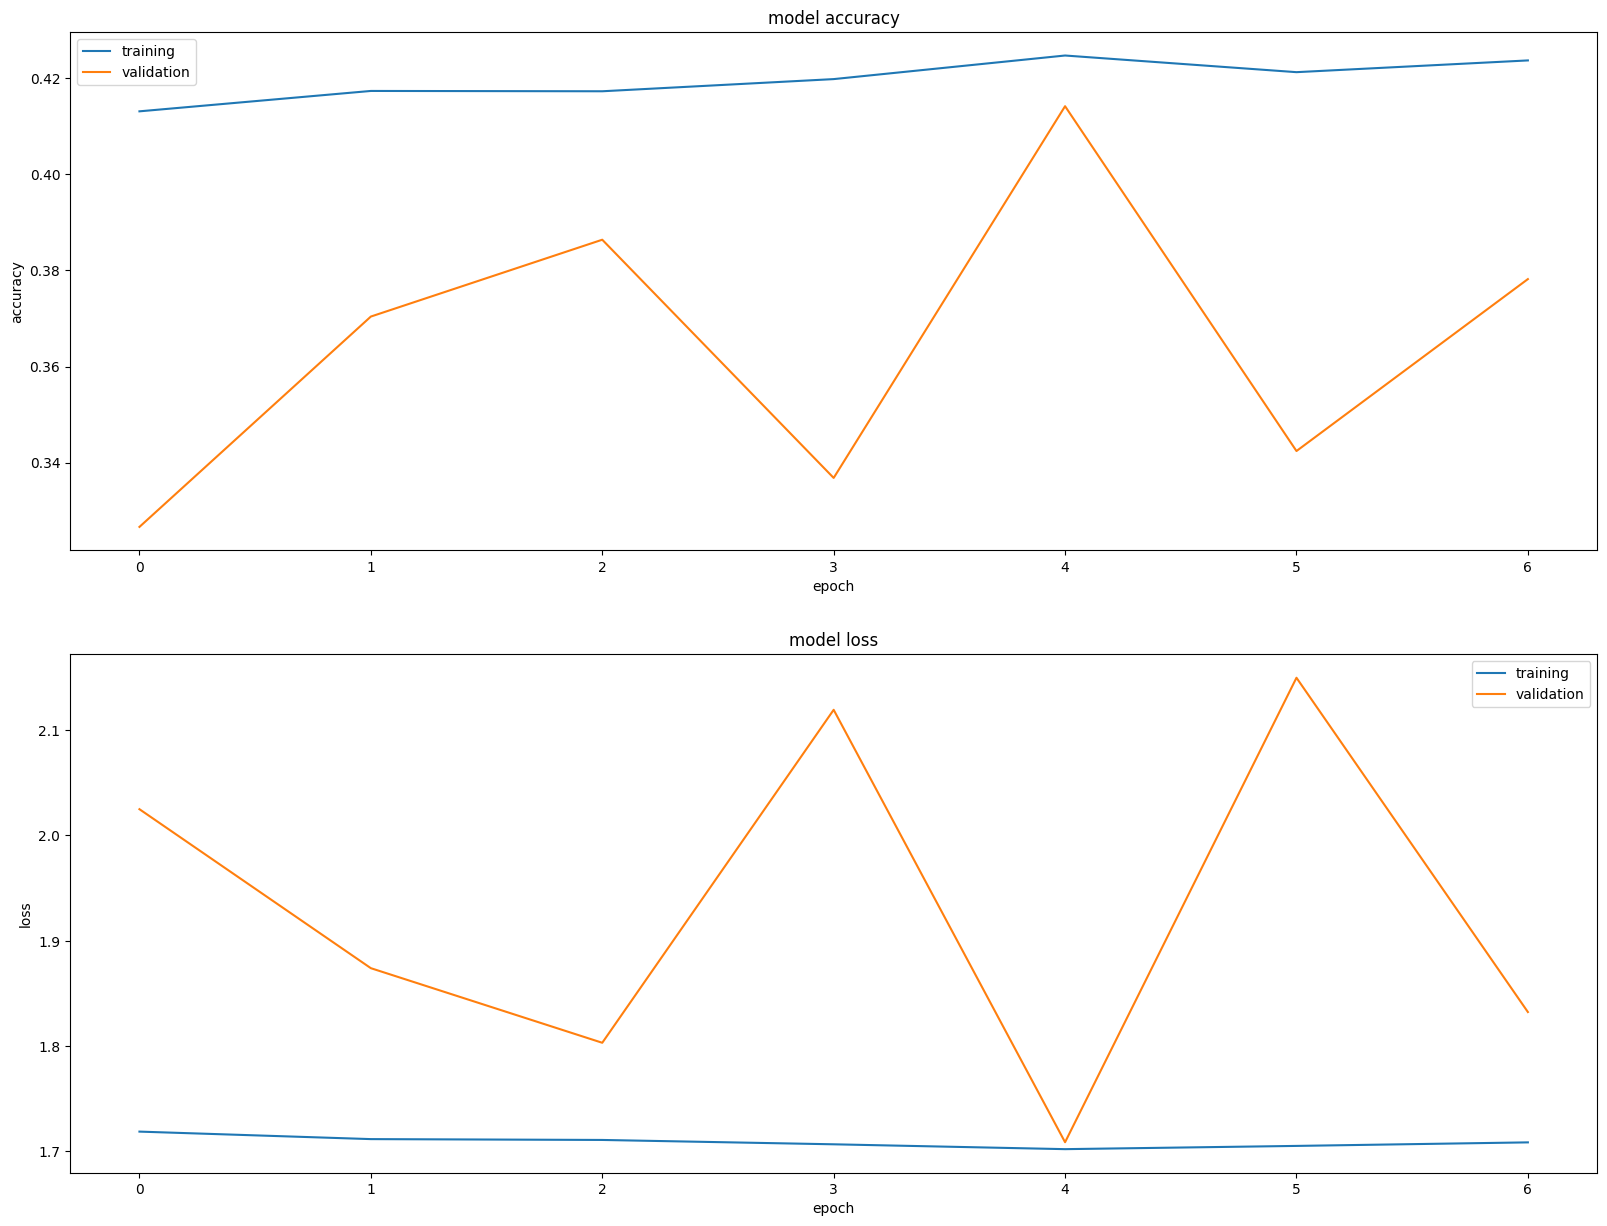

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history7.history['accuracy'], history7.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history7.history['loss'], history7.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 4ms/step


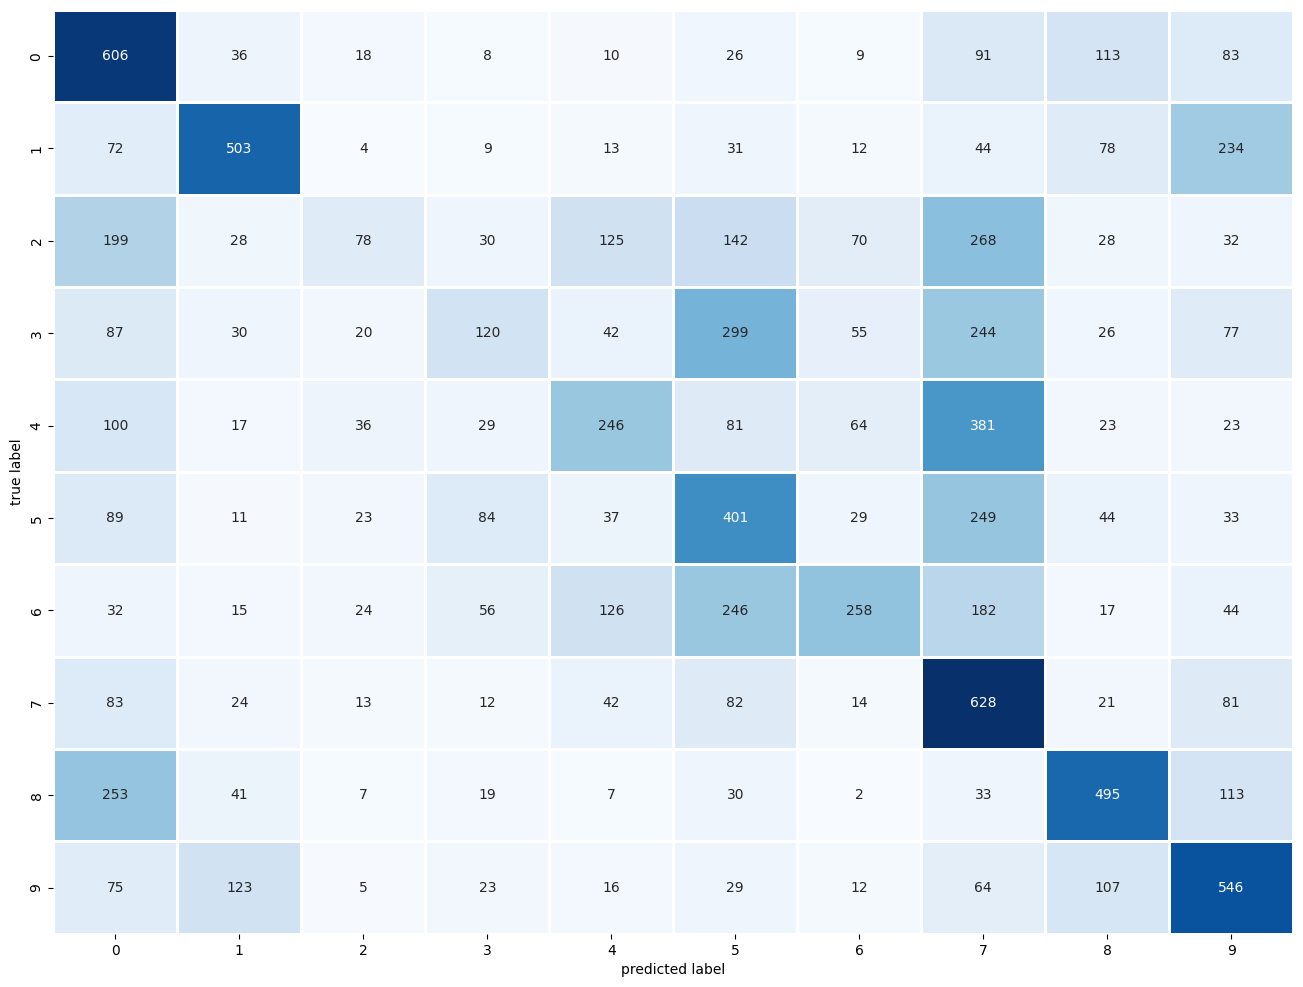

In [ ]:
pred7= model7.predict(x_test_norm)
pred7=np.argmax(pred7, axis=1)

plot_confusion_matrix(y_test, pred7)

#Experiment 8 CNN with 2 layers (Batch Normalization, L2 0.001)

In [ ]:
model8 = Sequential([
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Flatten(),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    BatchNormalization(),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model8.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 512)       1180160   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 512)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4

In [ ]:
model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
start_time8 = time.time()
history8 = model8.fit(x_train_norm
                    ,y_train_split
                    ,epochs=30
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time8 = time.time()

Epoch 1/30
88/88 [==============================] - 28s 201ms/step - loss: 1.7850 - accuracy: 0.5239 - val_loss: 1.9781 - val_accuracy: 0.5798
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 11s 129ms/step - loss: 1.1825 - accuracy: 0.6777 - val_loss: 1.6794 - val_accuracy: 0.5668
Epoch 3/30
88/88 [==============================] - 12s 135ms/step - loss: 0.9926 - accuracy: 0.7309 - val_loss: 1.7256 - val_accuracy: 0.4684
Epoch 4/30
88/88 [==============================] - 12s 134ms/step - loss: 0.8780 - accuracy: 0.7687 - val_loss: 1.3539 - val_accuracy: 0.6134
Epoch 5/30
88/88 [==============================] - 12s 132ms/step - loss: 0.7851 - accuracy: 0.8058 - val_loss: 1.2524 - val_accuracy: 0.6436
Epoch 6/30
88/88 [==============================] - 11s 127ms/step - loss: 0.7100 - accuracy: 0.8360 - val_loss: 1.2897 - val_accuracy: 0.6376
Epoch 7/30
88/88 [==============================] - 11s 129ms/step - loss: 0.6423 - accuracy: 0.8610 - val_loss: 1.2898 - val_accuracy: 0.6602
Epoch 8/30
88/88 [==============================] - 12s 131ms/step - loss: 0.5879 - accuracy: 0.8832 - val_loss: 1.2448 - val_accuracy: 0.6872
Epoch 9/30

In [ ]:
#evaluate the model
model8 = tf.keras.models.load_model("CNN_model.h5")
print(f"Test accuracy: {model8.evaluate(x_test_norm, y_test)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy8 = history8.history['accuracy']
validation_accuracy8 = history8.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy8[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy8[-1]:.3f}")

# Processing time
processing_time8 = end_time8 - start_time8
print(f'Model training time: {processing_time8:.3f} seconds')


313/313 [==============================] - 2s 5ms/step - loss: 1.1385 - accuracy: 0.7251
Test accuracy: 0.725
Training accuracy: 0.939
Validation accuracy: 0.706
Model training time: 155.185 seconds


<ipython-input-4-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


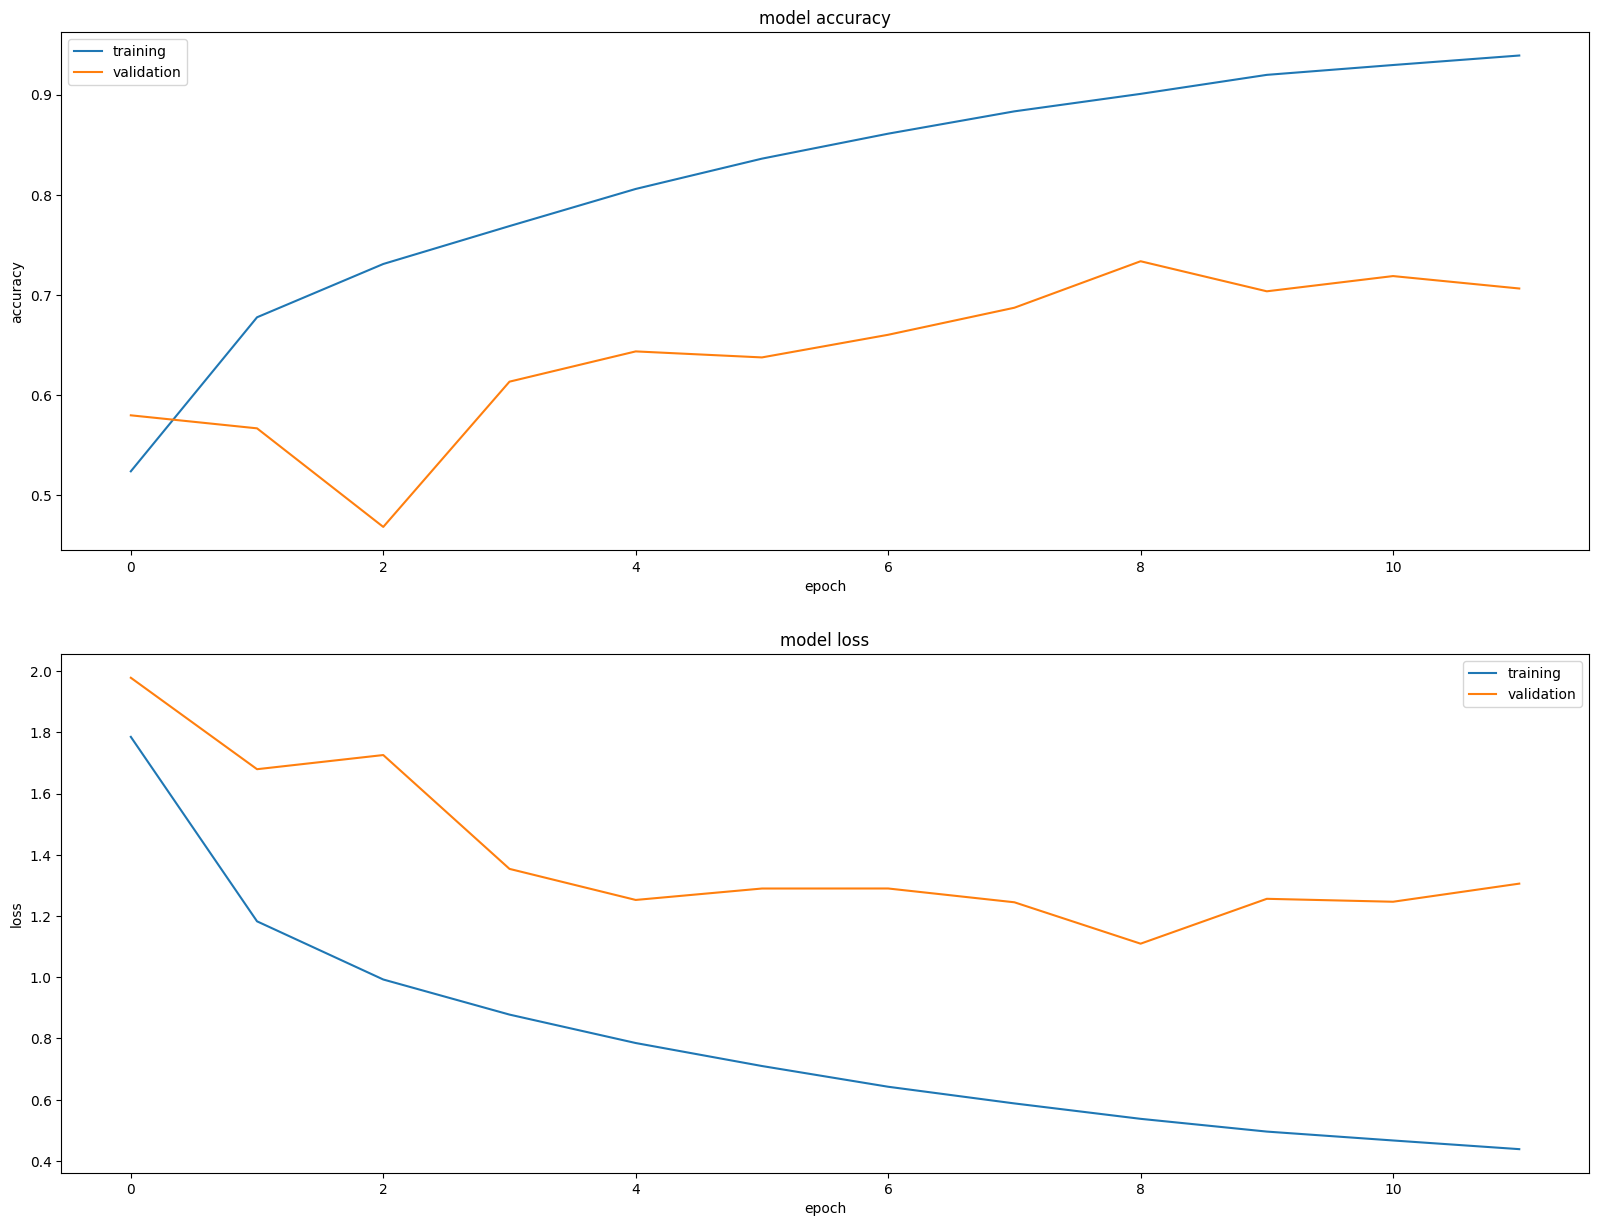

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history8.history['accuracy'], history8.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history8.history['loss'], history8.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 4ms/step


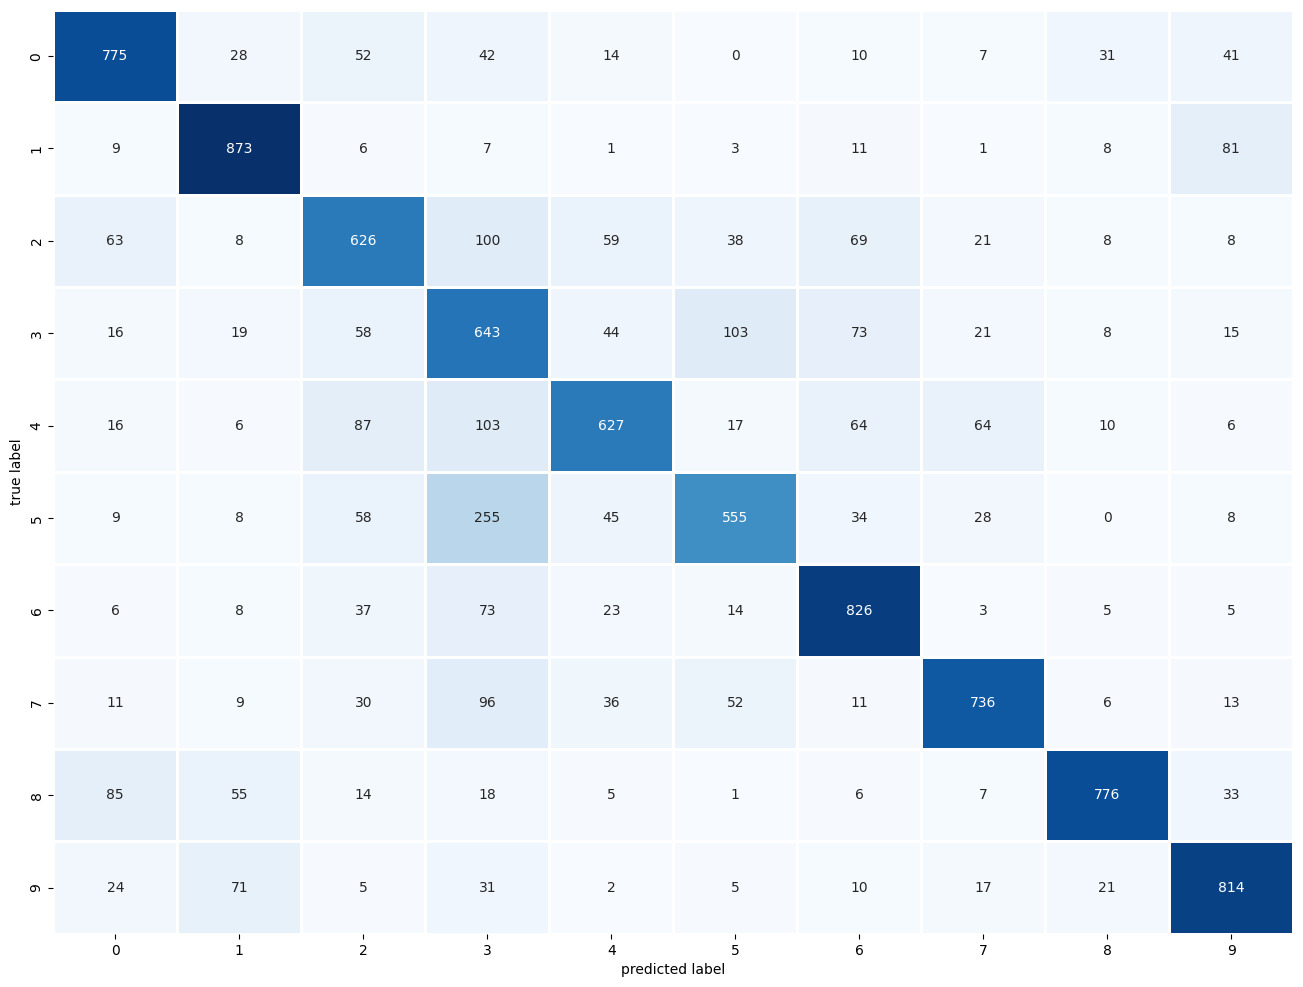

In [ ]:
pred8= model8.predict(x_test_norm)
pred8=np.argmax(pred8, axis=1)

plot_confusion_matrix(y_test, pred8)

#Experiment 9 CNN with 2 layers (Batch Normalization, L2 0.001, Dropout 0.25)

In [ ]:
model9 = Sequential([
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.25),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)
])

In [ ]:
model9.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 256)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 512)       1180160   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 512)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 512)        

In [ ]:
model9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
start_time9 = time.time()
history9 = model9.fit(x_train_norm
                    ,y_train_split
                    ,epochs=30
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time9 = time.time()

Epoch 1/30
88/88 [==============================] - 18s 165ms/step - loss: 2.2391 - accuracy: 0.4012 - val_loss: 2.3601 - val_accuracy: 0.3384
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 14s 165ms/step - loss: 1.5169 - accuracy: 0.5810 - val_loss: 1.9045 - val_accuracy: 0.4644
Epoch 3/30
88/88 [==============================] - 14s 162ms/step - loss: 1.2686 - accuracy: 0.6458 - val_loss: 1.6921 - val_accuracy: 0.5308
Epoch 4/30
88/88 [==============================] - 14s 158ms/step - loss: 1.1347 - accuracy: 0.6845 - val_loss: 1.3462 - val_accuracy: 0.6284
Epoch 5/30
88/88 [==============================] - 14s 154ms/step - loss: 1.0552 - accuracy: 0.7093 - val_loss: 1.2172 - val_accuracy: 0.6686
Epoch 6/30
88/88 [==============================] - 14s 154ms/step - loss: 0.9899 - accuracy: 0.7344 - val_loss: 1.1655 - val_accuracy: 0.6698
Epoch 7/30
88/88 [==============================] - 14s 158ms/step - loss: 0.9419 - accuracy: 0.7540 - val_loss: 1.0709 - val_accuracy: 0.7154
Epoch 8/30
88/88 [==============================] - 14s 155ms/step - loss: 0.9206 - accuracy: 0.7618 - val_loss: 1.0692 - val_accuracy: 0.7106
Epoch 9/30

In [ ]:
#evaluate the model
model9 = tf.keras.models.load_model("CNN_model.h5")
print(f"Test accuracy: {model9.evaluate(x_test_norm, y_test)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy9 = history9.history['accuracy']
validation_accuracy9 = history9.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy9[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy9[-1]:.3f}")

# Processing time
processing_time9 = end_time9 - start_time9
print(f'Model training time: {processing_time9:.3f} seconds')

313/313 [==============================] - 2s 5ms/step - loss: 1.0450 - accuracy: 0.7456
Test accuracy: 0.746
Training accuracy: 0.862
Validation accuracy: 0.754
Model training time: 279.607 seconds


<ipython-input-4-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


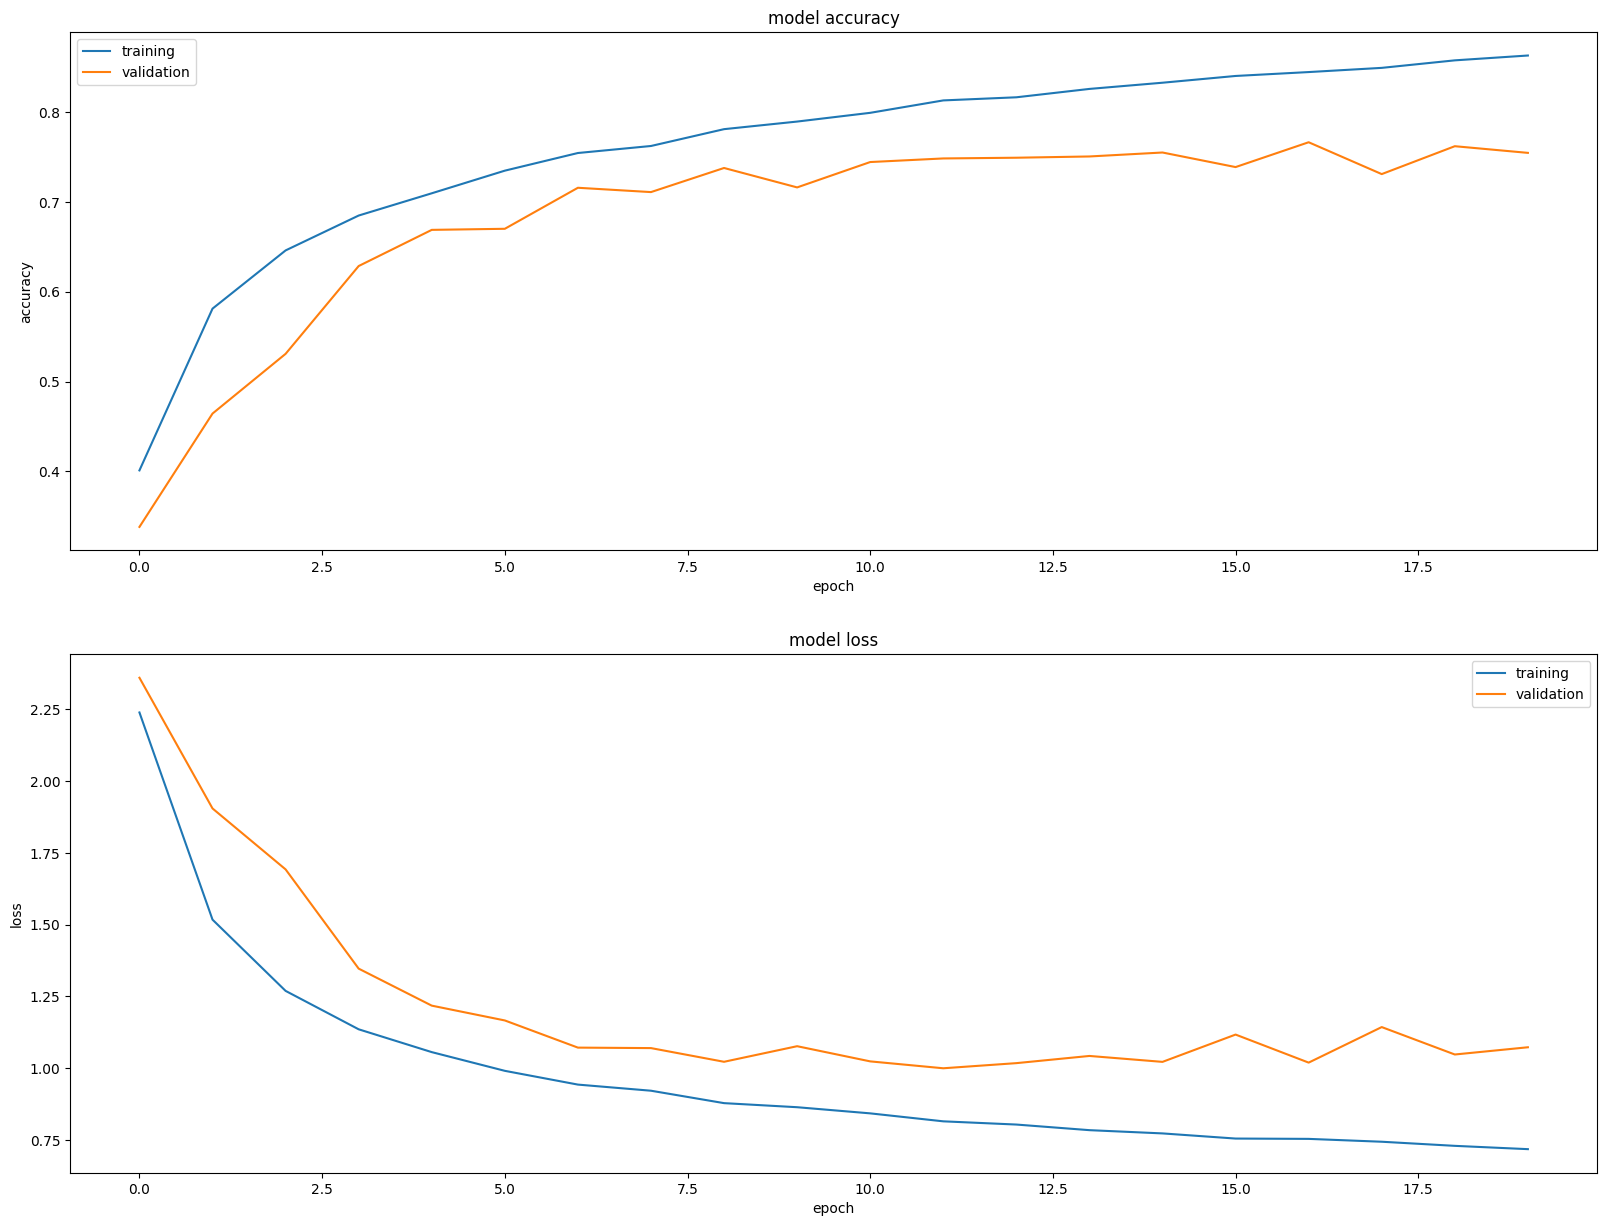

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history9.history['accuracy'], history9.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history9.history['loss'], history9.history['val_loss'], 'loss', 212)

313/313 [==============================] - 1s 3ms/step


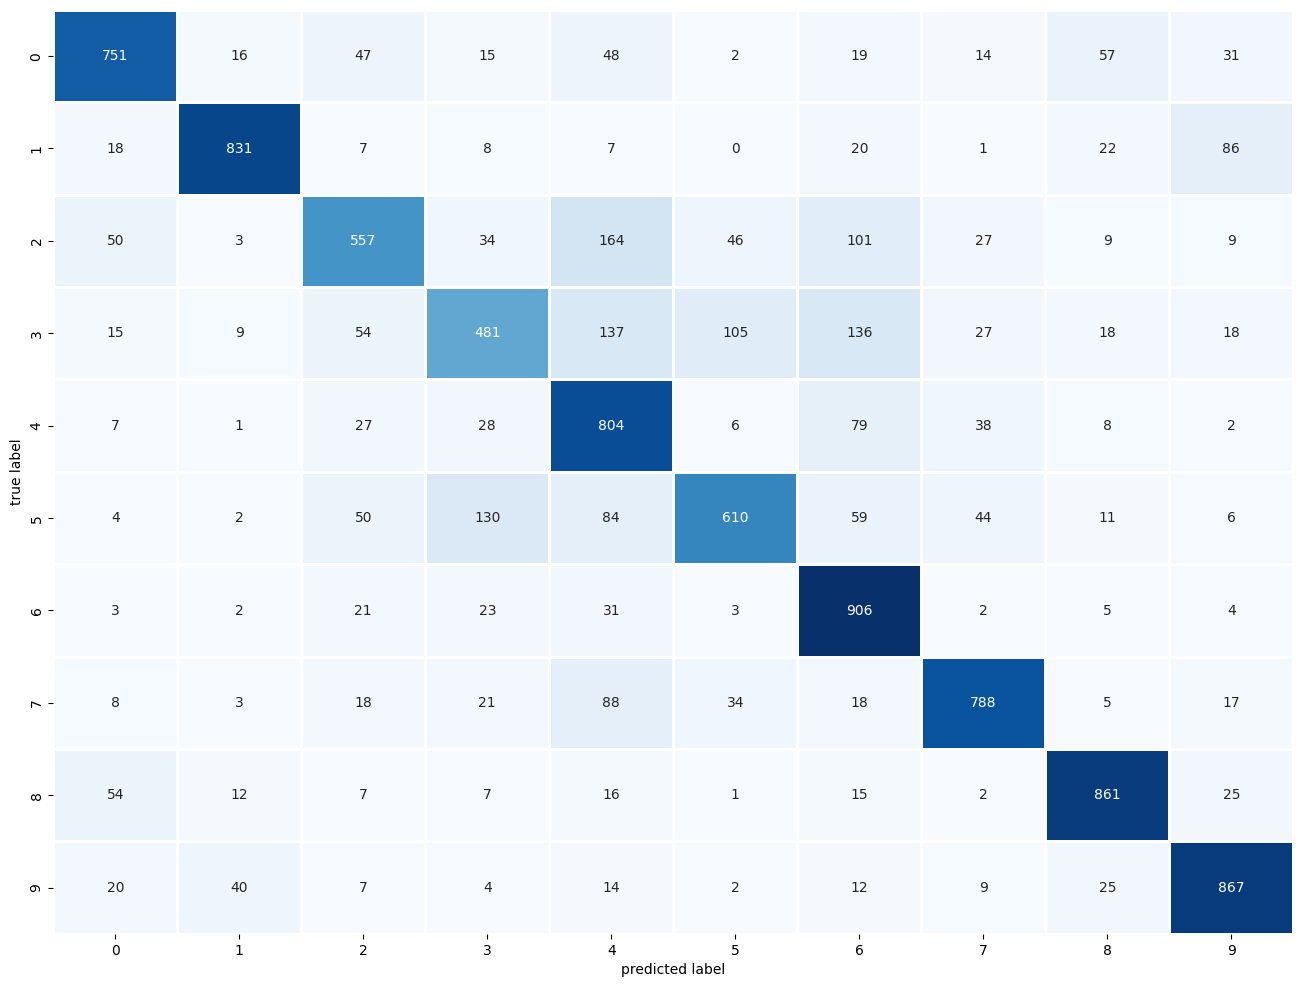

In [ ]:
pred9= model9.predict(x_test_norm)
pred9=np.argmax(pred9, axis=1)

plot_confusion_matrix(y_test, pred9)

#Experiment 10 CNN with 3 layers (Batch Normalization, L2 0.001, Dropout 0.25)

In [13]:
model10 = Sequential([
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.25),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.25),
    Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.25),
    Flatten(),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dropout(0.25),
    Dense(units=10, activation=tf.nn.softmax)
])


In [ ]:
model10.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 256)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 512)       1180160   
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 512)         0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 6, 6, 512)        

In [14]:
model10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
start_time10 = time.time()
history10 = model10.fit(x_train_norm
                    ,y_train_split
                    ,epochs=30
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time10 = time.time()

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 2.4155 - accuracy: 0.3025

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 47s 329ms/step - loss: 2.4155 - accuracy: 0.3025 - val_loss: 2.2093 - val_accuracy: 0.4064
Epoch 2/30
88/88 [==============================] - 16s 178ms/step - loss: 1.6345 - accuracy: 0.5135 - val_loss: 2.3957 - val_accuracy: 0.2830
Epoch 3/30
88/88 [==============================] - 16s 184ms/step - loss: 1.3163 - accuracy: 0.6058 - val_loss: 1.6505 - val_accuracy: 0.5076
Epoch 4/30
88/88 [==============================] - 16s 181ms/step - loss: 1.1268 - accuracy: 0.6608 - val_loss: 1.6138 - val_accuracy: 0.5006
Epoch 5/30
88/88 [==============================] - 17s 188ms/step - loss: 1.0039 - accuracy: 0.6980 - val_loss: 1.1857 - val_accuracy: 0.6462
Epoch 6/30
88/88 [==============================] - 16s 185ms/step - loss: 0.9130 - accuracy: 0.7291 - val_loss: 0.9805 - val_accuracy: 0.7050
Epoch 7/30
88/88 [==============================] - 16s 185ms/step - loss: 0.8237 - accuracy: 0.7577 - val_loss: 0.8391 - val_accuracy: 0.7472
Epoch 8/30

In [ ]:
#evaluate the model
model10 = tf.keras.models.load_model("CNN_model.h5")
print(f"Test accuracy: {model10.evaluate(x_test_norm, y_test)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy10 = history10.history['accuracy']
validation_accuracy10 = history10.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy10[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy10[-1]:.3f}")

# Processing time
processing_time10 = end_time10 - start_time10
print(f'Model training time: {processing_time10:.3f} seconds')

313/313 [==============================] - 3s 8ms/step - loss: 0.7495 - accuracy: 0.7901
Test accuracy: 0.790
Training accuracy: 0.859
Validation accuracy: 0.798
Model training time: 256.267 seconds


<ipython-input-4-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


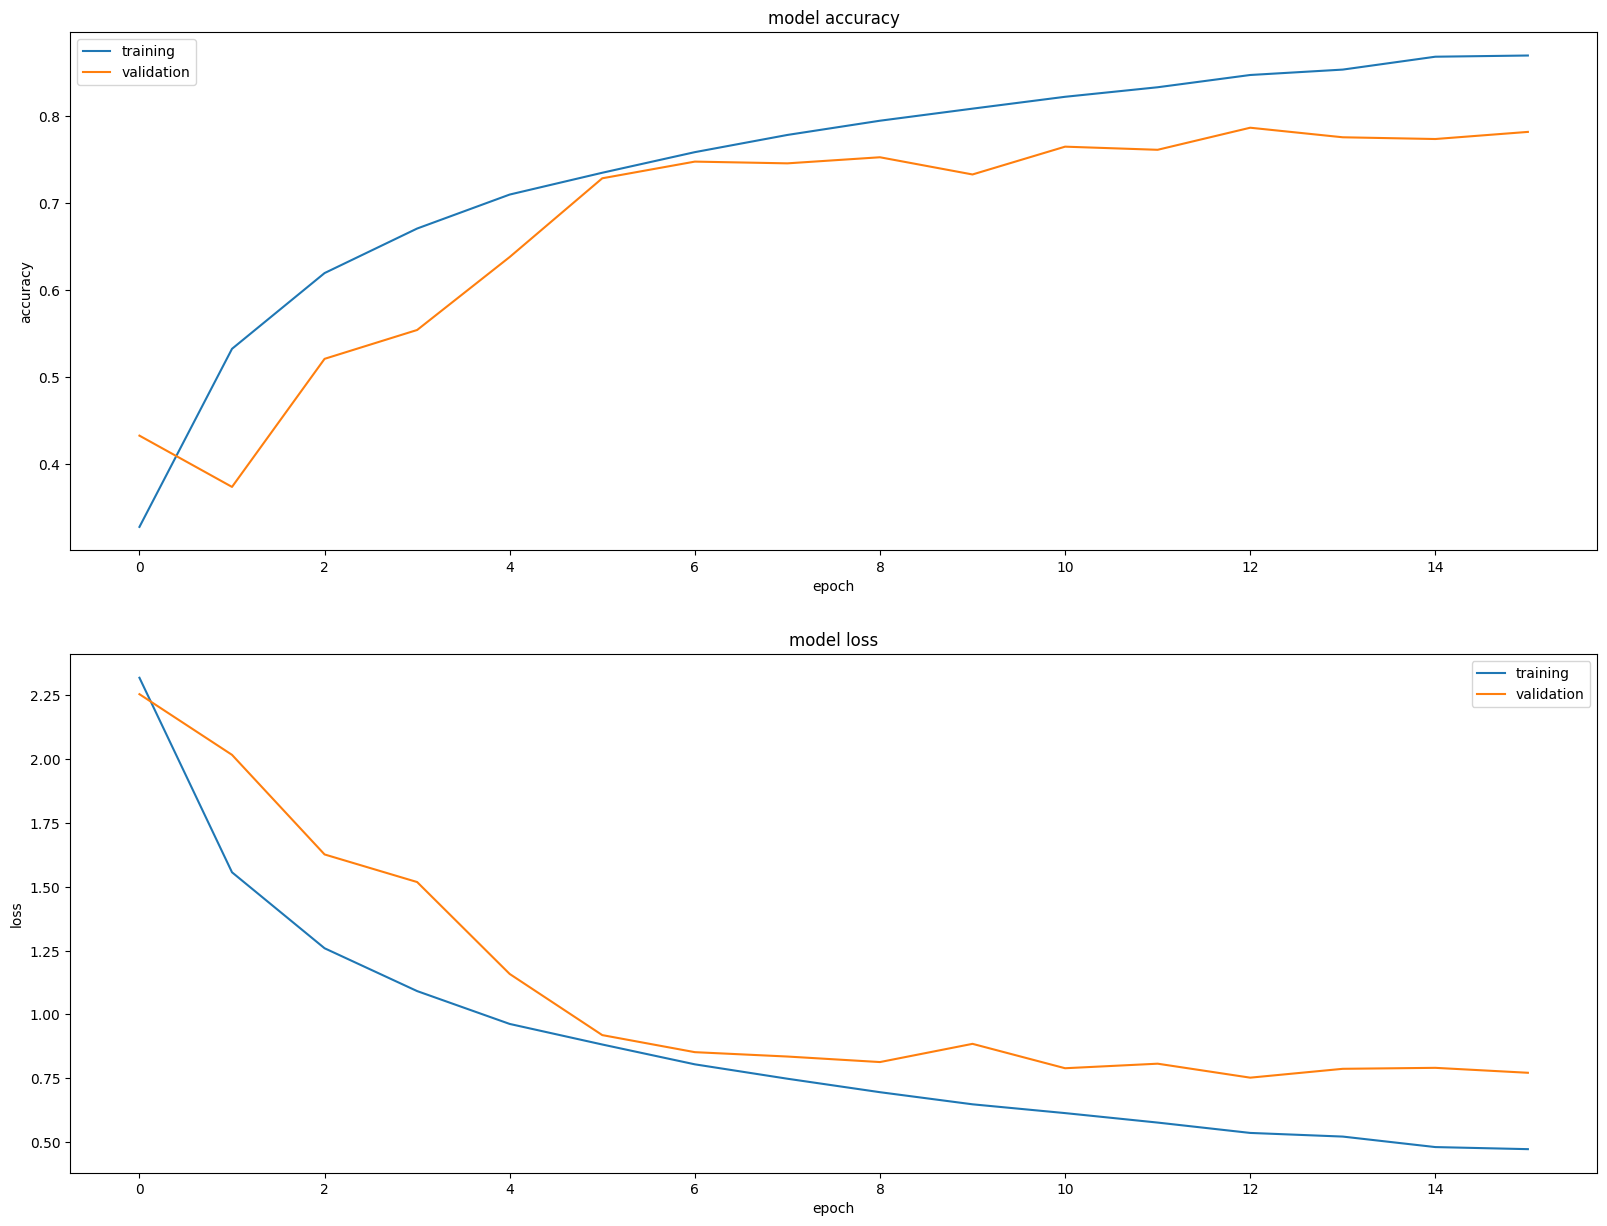

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history10.history['accuracy'], history10.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history10.history['loss'], history10.history['val_loss'], 'loss', 212)

313/313 [==============================] - 2s 5ms/step


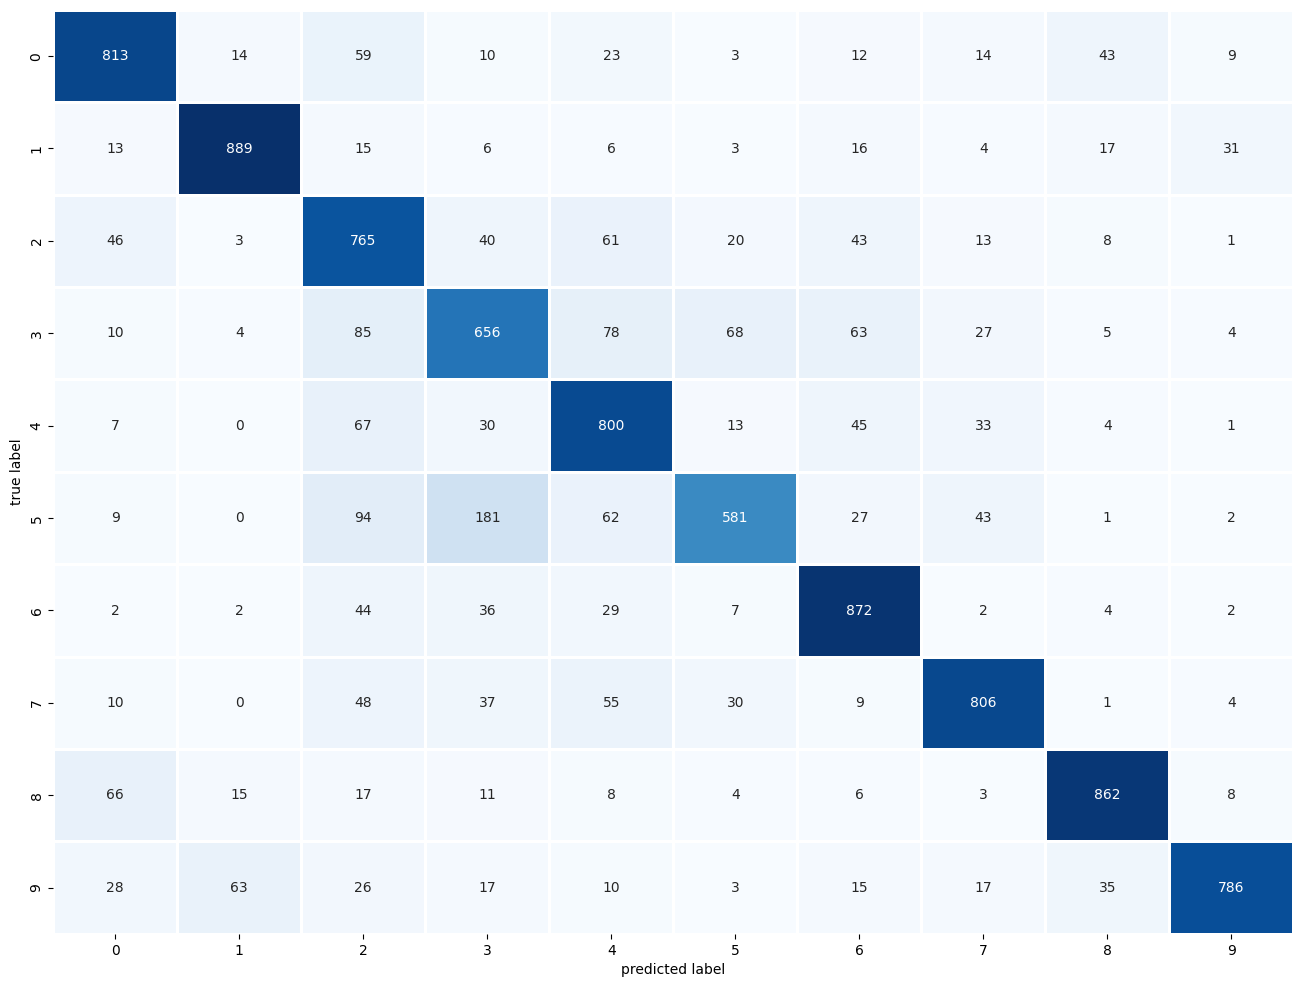

In [ ]:
pred10= model10.predict(x_test_norm)
pred10=np.argmax(pred10, axis=1)

plot_confusion_matrix(y_test, pred10)

## sklearn.manifold.TSNE

In [17]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model10.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model10.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:1000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]


32/32 [==============================] - 1s 15ms/step


In [16]:
from sklearn.manifold import TSNE


In [18]:
# Limit the number of samples to reduce RAM usage
sample_size = 1000  #number of samples
dense_layer_activations_sampled = dense_layer_activations[:sample_size]

# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations_sampled)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.098040
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.787590
[t-SNE] KL divergence after 300 iterations: 0.960168


In [19]:
import numpy as np

# Flatten dense_layer_activations
flattened_activations = dense_layer_activations.reshape(dense_layer_activations.shape[0], -1)

# Reduce the dimension using T-SNE to visualize in a scatterplot
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(flattened_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.098040
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.787498
[t-SNE] KL divergence after 300 iterations: 0.960153


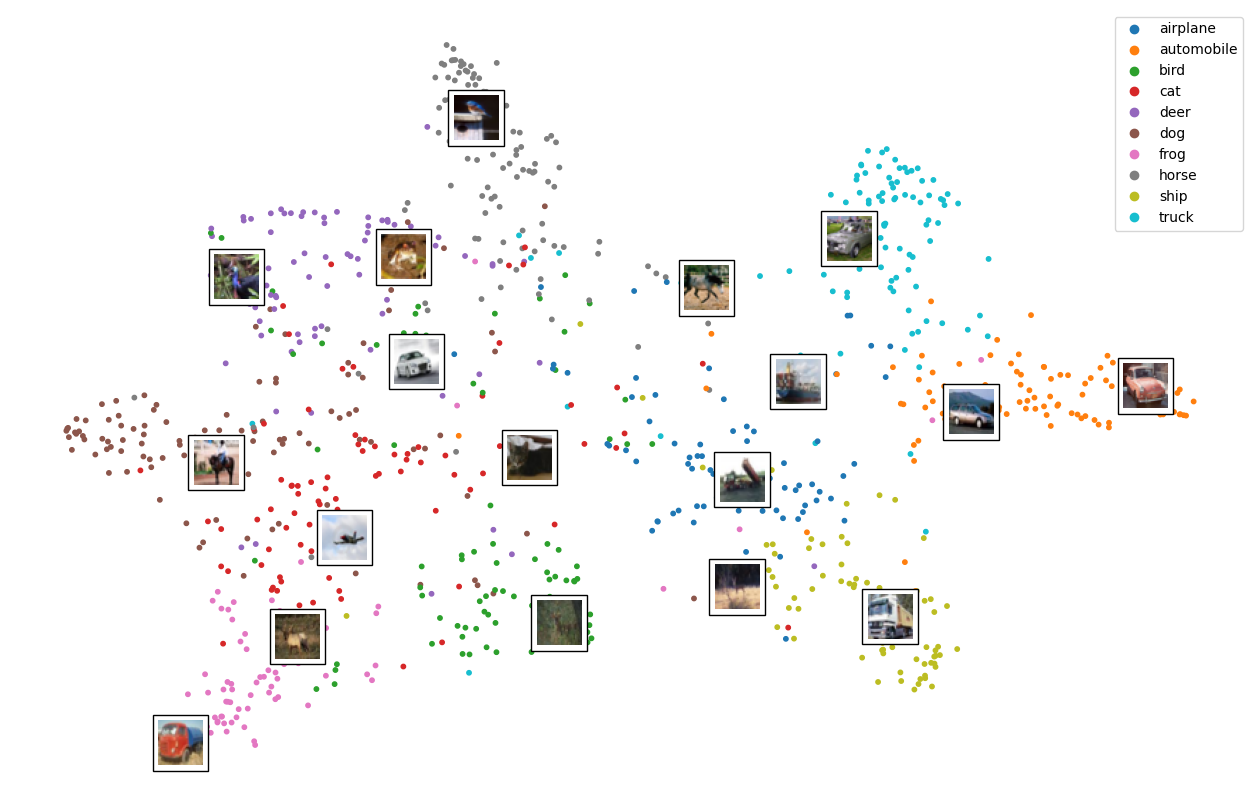

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.offsetbox as offsetbox

cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_valid_split[:1000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:  # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()



#Experiment 11 CNN with 3 layers (Batch Normalization, L2 0.001, Dropout 0.5)

In [27]:
model11 = Sequential([
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=x_train_norm.shape[1:]),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.5),
    Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.5),
    Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    MaxPool2D((2, 2), strides=2),
    Dropout(0.5),
    Flatten(),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=256, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dropout(0.5),
    Dense(units=10, activation=tf.nn.softmax)
])


In [ ]:
model11.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 512)       1180160   
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 512)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 512)         0

In [28]:
model11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
start_time11 = time.time()
history11 = model11.fit(x_train_norm
                    ,y_train_split
                    ,epochs=30
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model.h5",save_best_only=True,save_weights_only=False)
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]
                   )
end_time11 = time.time()

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 2.9923 - accuracy: 0.1757

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 19s 185ms/step - loss: 2.9923 - accuracy: 0.1757 - val_loss: 2.6186 - val_accuracy: 0.2318
Epoch 2/30
88/88 [==============================] - 17s 190ms/step - loss: 2.2766 - accuracy: 0.3101 - val_loss: 2.6024 - val_accuracy: 0.2476
Epoch 3/30
88/88 [==============================] - 16s 183ms/step - loss: 1.8831 - accuracy: 0.4327 - val_loss: 2.4208 - val_accuracy: 0.2770
Epoch 4/30
88/88 [==============================] - 16s 185ms/step - loss: 1.6661 - accuracy: 0.4942 - val_loss: 1.9435 - val_accuracy: 0.4330
Epoch 5/30
88/88 [==============================] - 16s 185ms/step - loss: 1.5087 - accuracy: 0.5404 - val_loss: 1.6412 - val_accuracy: 0.5340
Epoch 6/30
88/88 [==============================] - 17s 196ms/step - loss: 1.4004 - accuracy: 0.5748 - val_loss: 1.3523 - val_accuracy: 0.6064
Epoch 7/30
88/88 [==============================] - 17s 190ms/step - loss: 1.3049 - accuracy: 0.6031 - val_loss: 1.1915 - val_accuracy: 0.6454
Epoch 8/30

In [ ]:
#evaluate the model
model11 = tf.keras.models.load_model("CNN_model.h5")
print(f"Test accuracy: {model11.evaluate(x_test_norm, y_test)[1]:.3f}")

# Get training and validation accuracy from history1
training_accuracy11 = history11.history['accuracy']
validation_accuracy11 = history11.history['val_accuracy']

# Print training and validation accuracy
print(f"Training accuracy: {training_accuracy11[-1]:.3f}")
print(f"Validation accuracy: {validation_accuracy11[-1]:.3f}")

# Processing time
processing_time11 = end_time11 - start_time11
print(f'Model training time: {processing_time11:.3f} seconds')

313/313 [==============================] - 3s 7ms/step - loss: 0.9519 - accuracy: 0.7233
Test accuracy: 0.723
Training accuracy: 0.704
Validation accuracy: 0.704
Model training time: 267.833 seconds


<ipython-input-4-353fbae40d9a>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


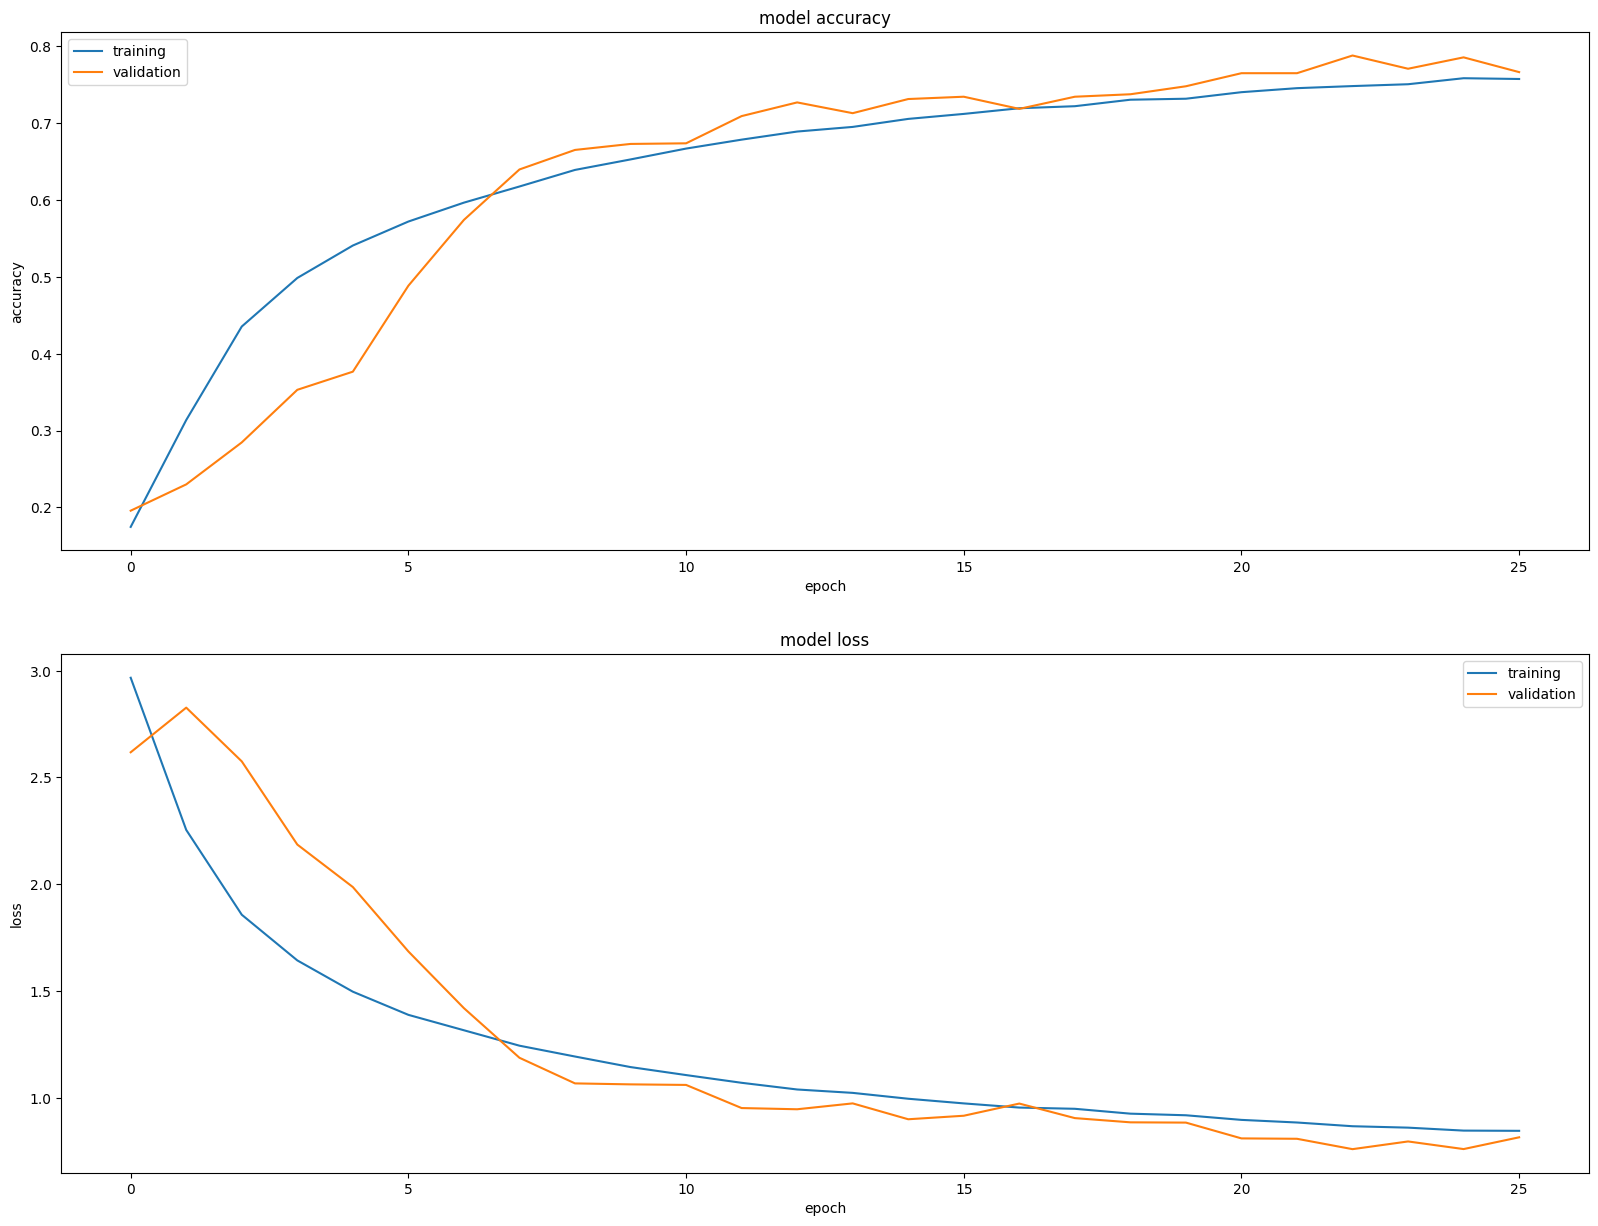

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history11.history['accuracy'], history11.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history11.history['loss'], history11.history['val_loss'], 'loss', 212)

313/313 [==============================] - 2s 5ms/step


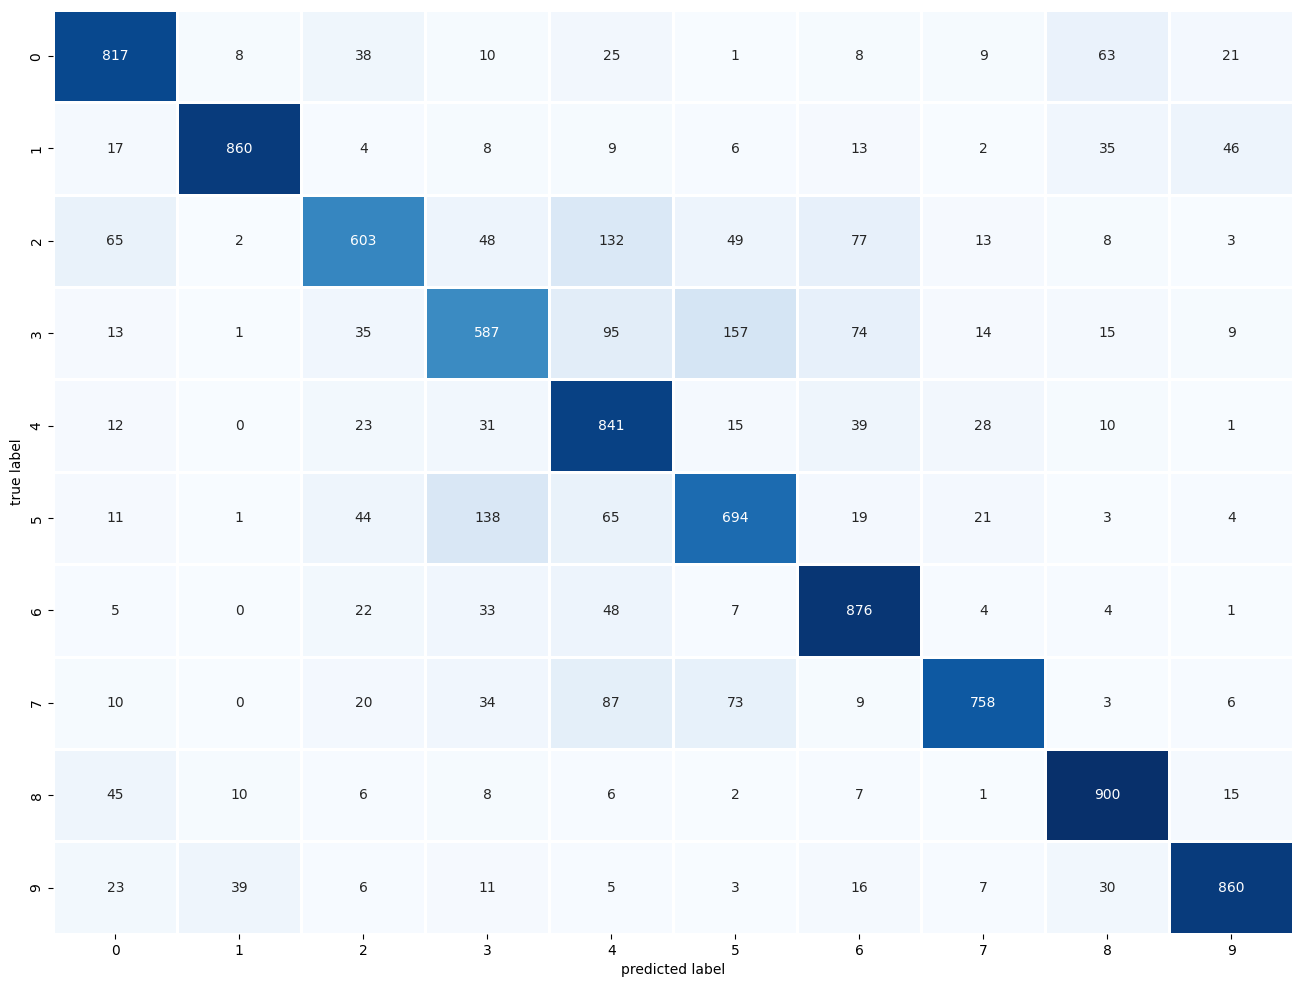

In [ ]:
pred11= model11.predict(x_test_norm)
pred11=np.argmax(pred11, axis=1)

plot_confusion_matrix(y_test, pred11)

## sklearn.manifold.TSNE

In [30]:
# Extracts the outputs of all layers:
layer_outputs = [layer.output for layer in model11.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model11.input, outputs=layer_outputs)

# Get activation values for the last dense layer
activations = activation_model.predict(x_valid_norm[:1000])
dense_layer_activations = activations[-3]
output_layer_activations = activations[-1]

32/32 [==============================] - 0s 7ms/step


In [31]:
# Limit the number of samples to reduce RAM usage
sample_size = 1000  #number of samples
dense_layer_activations_sampled = dense_layer_activations[:sample_size]

# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(dense_layer_activations_sampled)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.162614
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.599899
[t-SNE] KL divergence after 300 iterations: 0.897353


In [32]:


# Flatten dense_layer_activations
flattened_activations = dense_layer_activations.reshape(dense_layer_activations.shape[0], -1)

# Reduce the dimension using T-SNE to visualize in a scatterplot
tsne = TSNE(n_components=2, verbose=1, init='pca', learning_rate='auto', perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(flattened_activations)

# Scaling
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.162614
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.599503
[t-SNE] KL divergence after 300 iterations: 0.897390


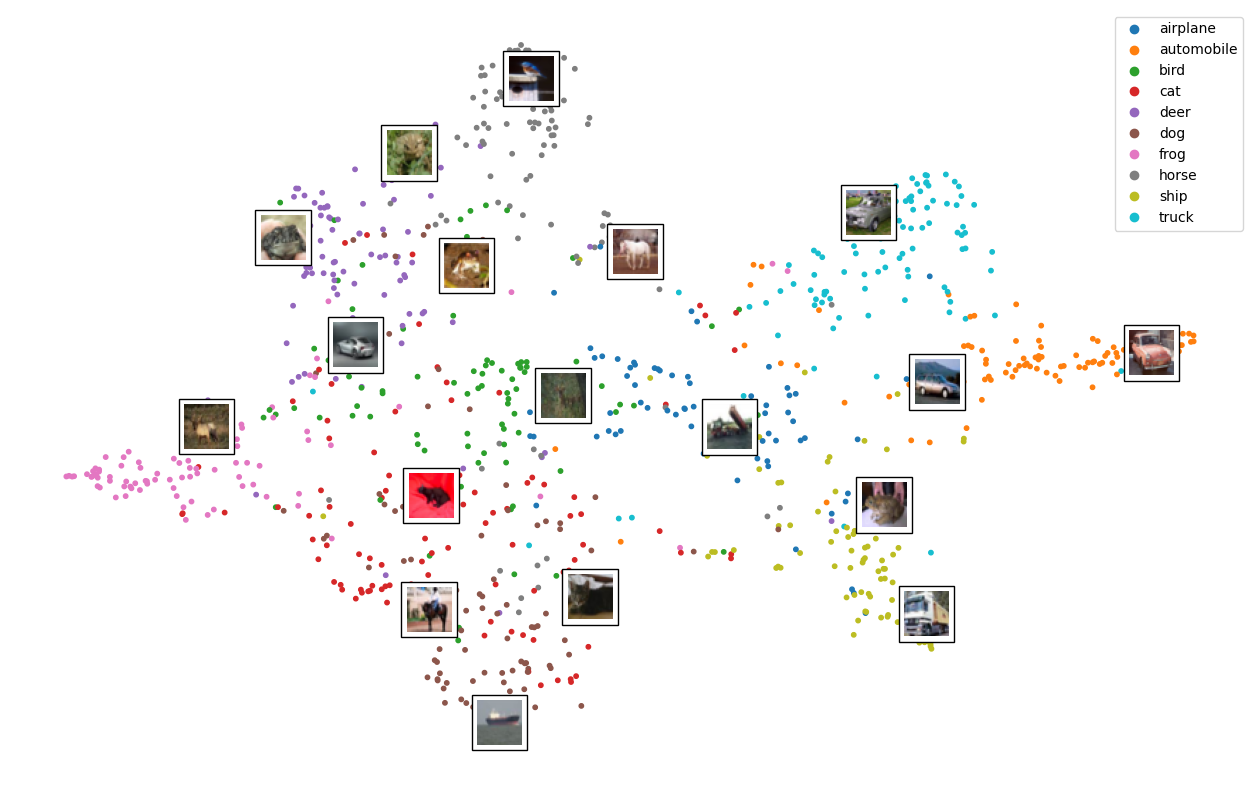

In [33]:
cmap = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=y_valid_split[:1000], s=10, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:  # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

In [1]:
%%shell
jupyter nbconvert --to html /MSDS458_Assignment_02_part01_20240324.ipynb

[NbConvertApp] Converting notebook /MSDS458_Assignment_02_part01_20240324.ipynb to html
[NbConvertApp] Writing 1974916 bytes to /MSDS458_Assignment_02_part01_20240324.html
